# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

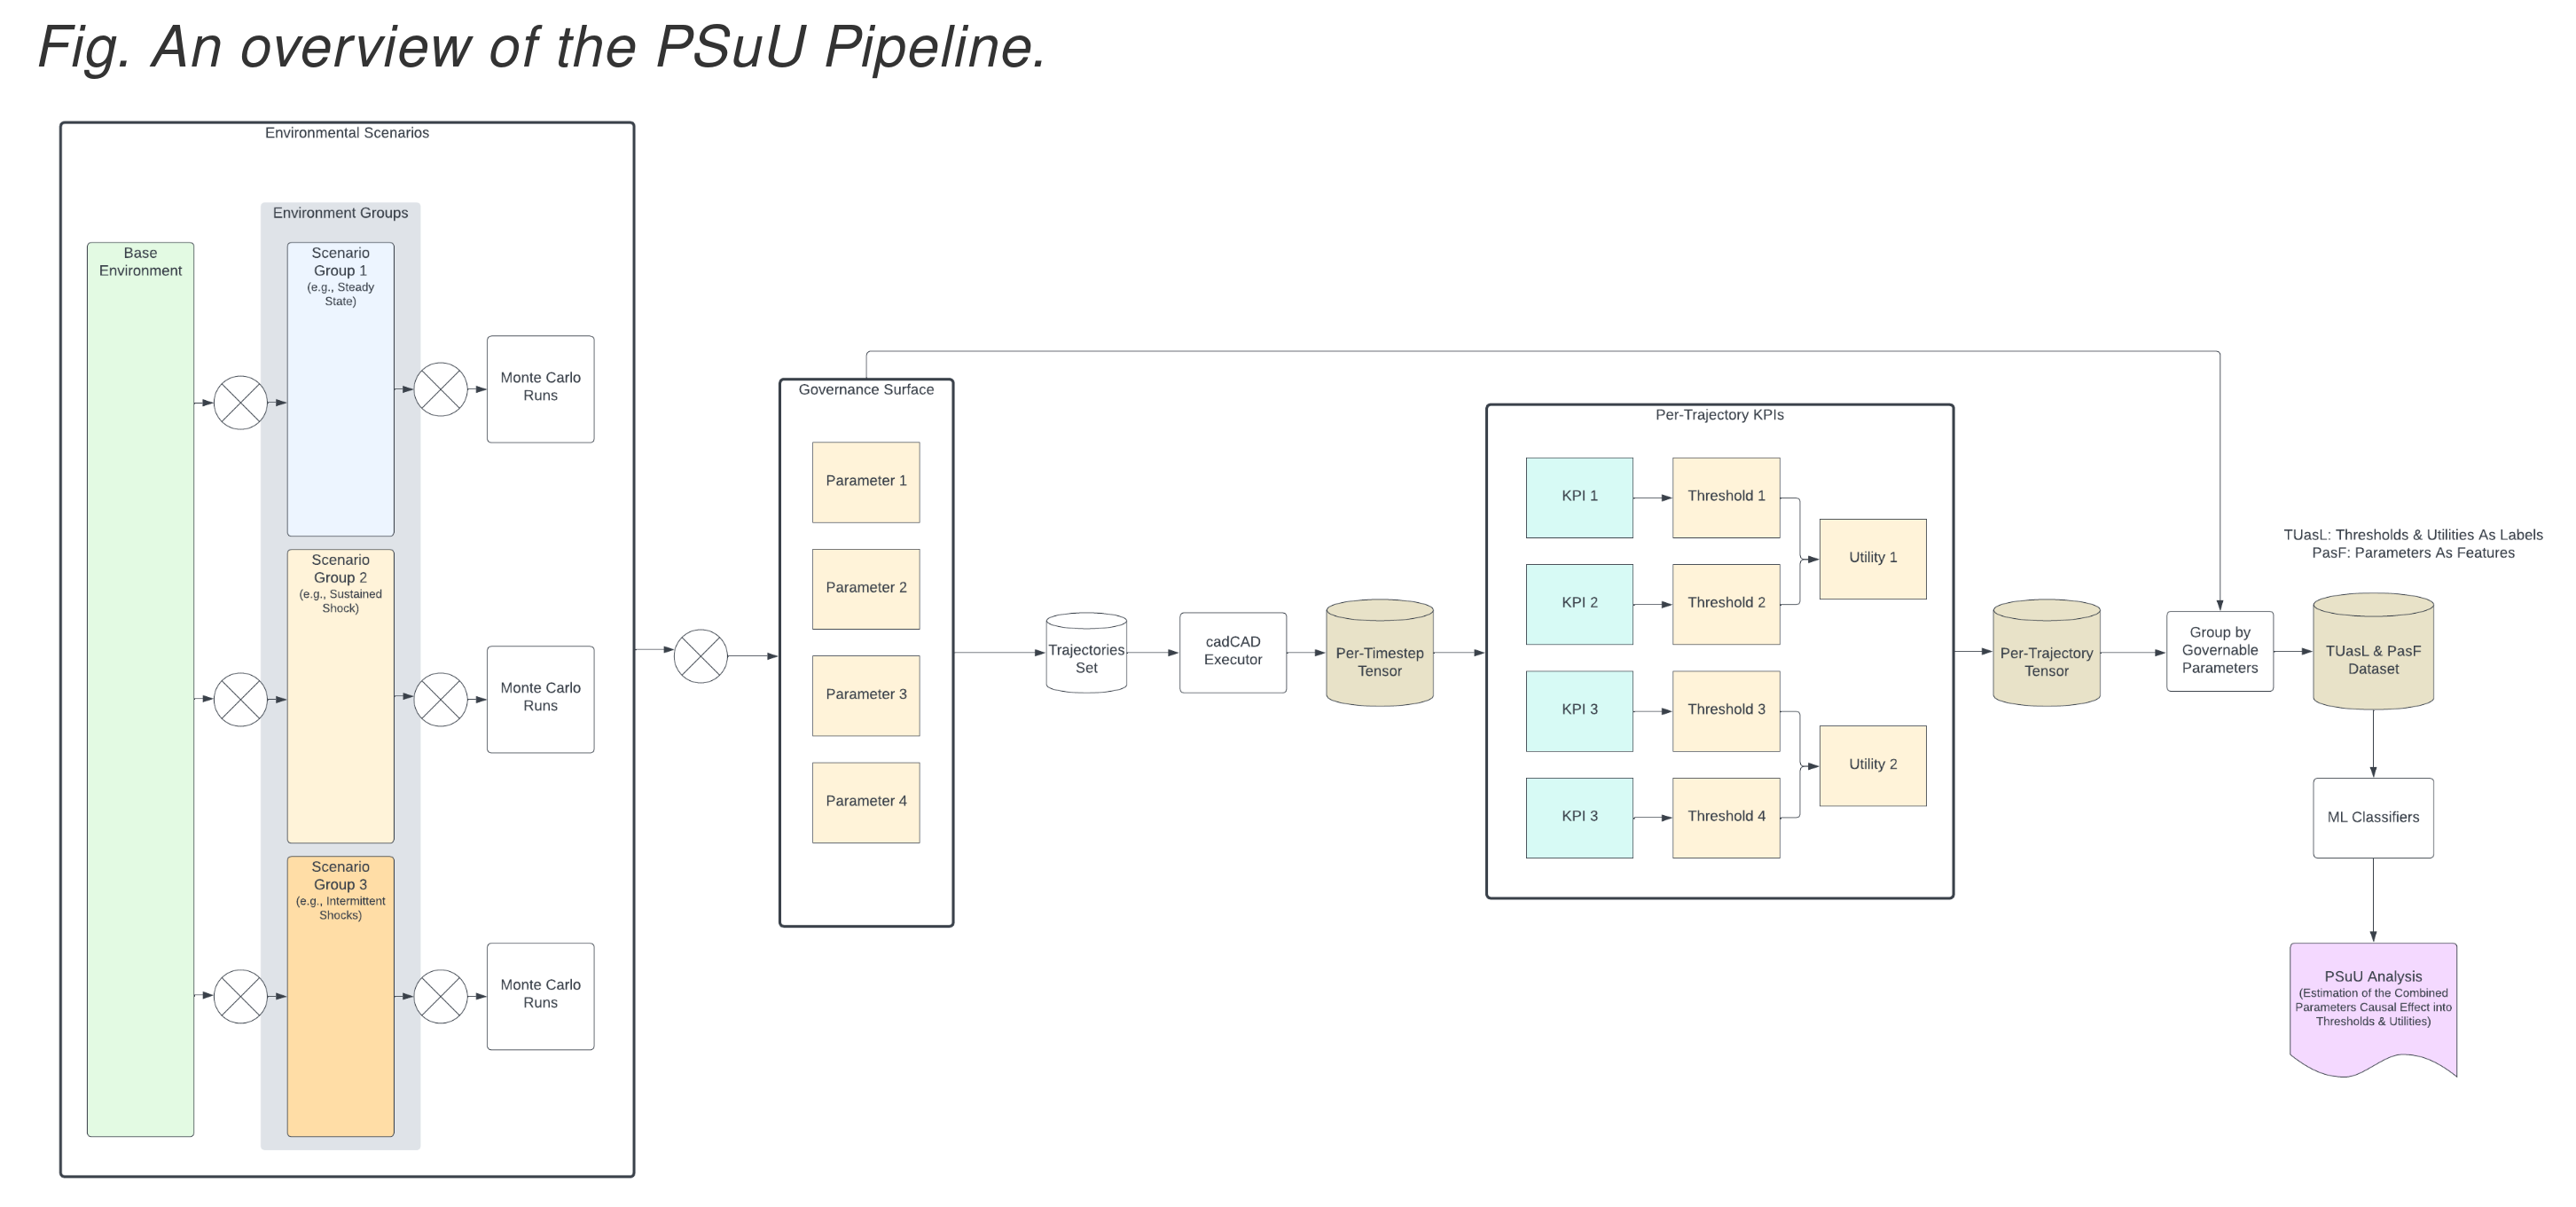

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd
import hvplot.pandas
import holoviews as hv
from typing import Callable, Dict, List, Tuple, Union
from tqdm.auto import tqdm

from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS

In [2]:
pd.set_option('display.max_columns', None)

lastest_folder = sorted(glob("../../data/simulations/psuu_run-*"))[-1]
files = [f for f in os.listdir(lastest_folder) if 'timestep_tensor' in f]

sim_df = pd.read_pickle(f"{lastest_folder}/{files[0]}", compression='gzip')

N_sweeps = len(sim_df.subset.unique())
N_runs = len(sim_df.run.unique())
N_trajectories = N_sweeps * N_runs
N_timesteps = len(sim_df.timestep.unique())
N_measurements = N_trajectories * N_timesteps

print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")

Tensor Size: N_measurements=438,800 over N_trajectories=400 | (N_sweeps=20, N_runs=20, N_timesteps=1,097)	


In [3]:
glob("../../data/")

['../../data/']

In [4]:
sim_df.days_passed.max()

1096.0

Aggregating trajectories.

In [5]:
traj_tensors = []
for file in tqdm(files):
    filepath = f"{lastest_folder}/{file}"
    _df = pd.read_pickle(filepath, compression='gzip')
    traj_tensors.append(timestep_tensor_to_trajectory_tensor(_df))

agg_df = pd.concat(traj_tensors).reset_index()

agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()

  0%|          | 0/25 [00:00<?, ?it/s]

simulation  mean_relative_community_owned_supply  \
count       500.0                            500.000000   
mean          0.0                              0.253225   
std           0.0                              0.028053   
min           0.0                              0.201646   
25%           0.0                              0.233760   
50%           0.0                              0.258372   
75%           0.0                              0.275165   
max           0.0                              0.308991   

       mean_farmer_subsidy_factor  \
count                  500.000000   
mean                     0.057238   
std                      0.050478   
min                      0.002140   
25%                      0.016446   
50%                      0.039516   
75%                      0.087657   
max                      0.284700   

       mean_proposing_rewards_per_newly_pledged_space  \
count                                    5.000000e+02   
mean                                     7.147134e-13   
std                                      3.453189e-13   
min                                      1.339830e-13   
25%                                      4.935761e-13   
50%                                      7.289573e-13   
75%                                      9.395125e-13   
max                                      1.377724e-12   

       mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
count                               500.000000             5.000000e+02   
mean                              98301.595595             7.953434e+07   
std                               47489.532158             3.557354e+07   
min                               18467.966273             1.578240e+07   
25%                               67915.624327             5.256000e+07   
50%                              100295.933580             8.409600e+07   
75%                              129275.769562             1.104768e+08   
max                              189415.788422             1.471680e+08   

       abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
count                               5.000000e+02  5.000000e+02  
mean                                4.238662e+09  1.960670e+08  
std                                 4.357263e+09  9.472003e+07  
min                                 1.088436e+08  3.683520e+07  
25%                                 1.058332e+09  1.354608e+08  
50%                                 2.202638e+09  2.000448e+08  
75%                                 6.929403e+09  2.578464e+08  
max                                 2.109734e+10  3.777984e+08

Kernal density estimate plots of KPI outcomes over trajectories.

Evaluating the utility tensor.

In [6]:


# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df, threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index

In [7]:
utility_df.reset_index(drop=True)
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

### Parameter Effect into System Goals

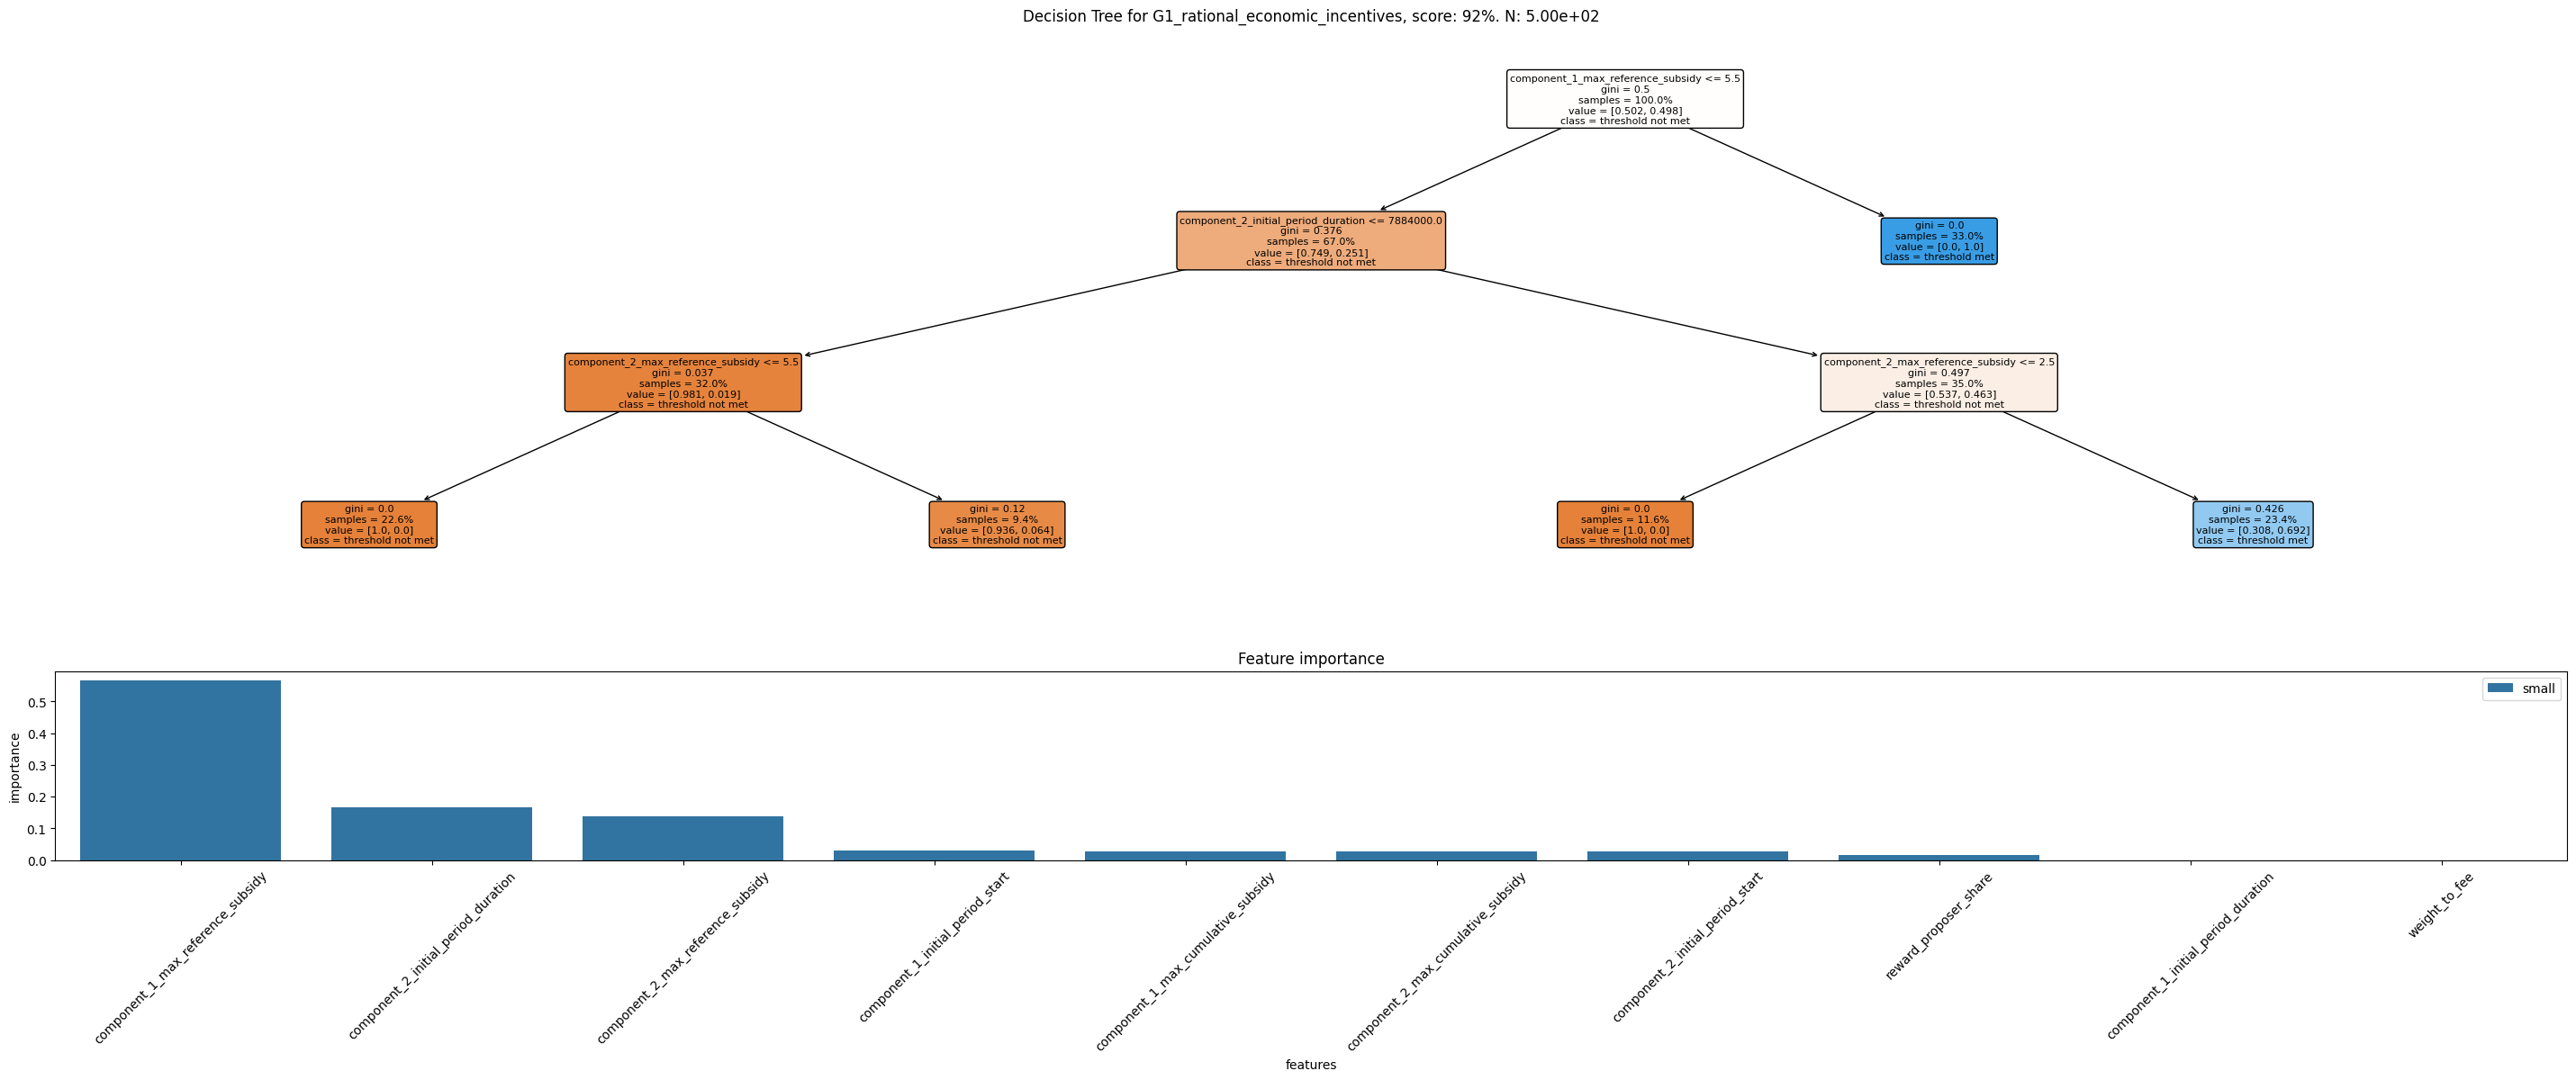

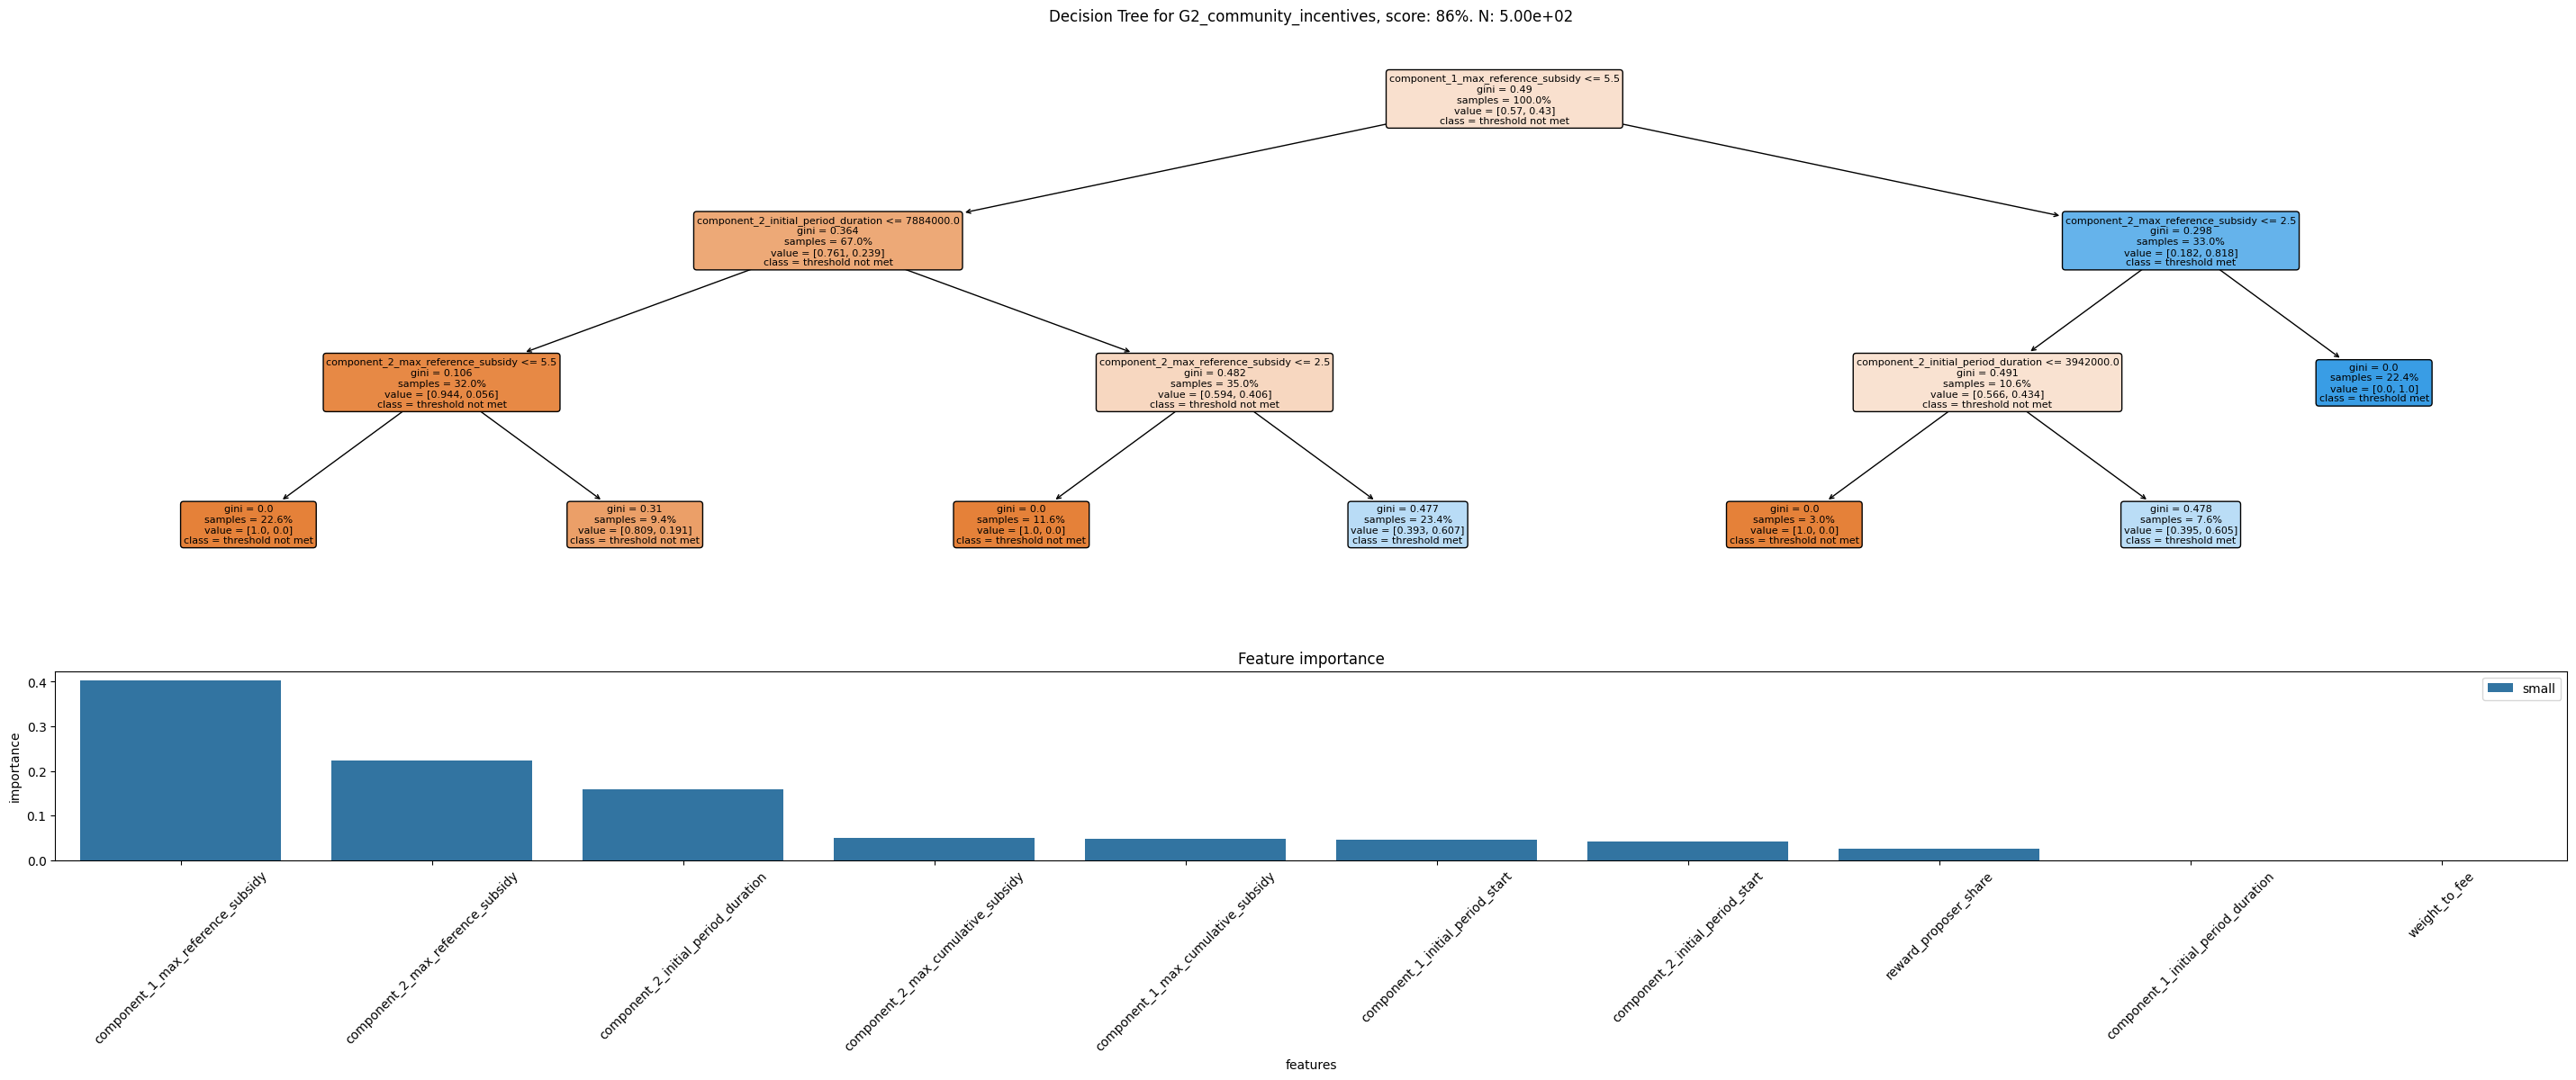

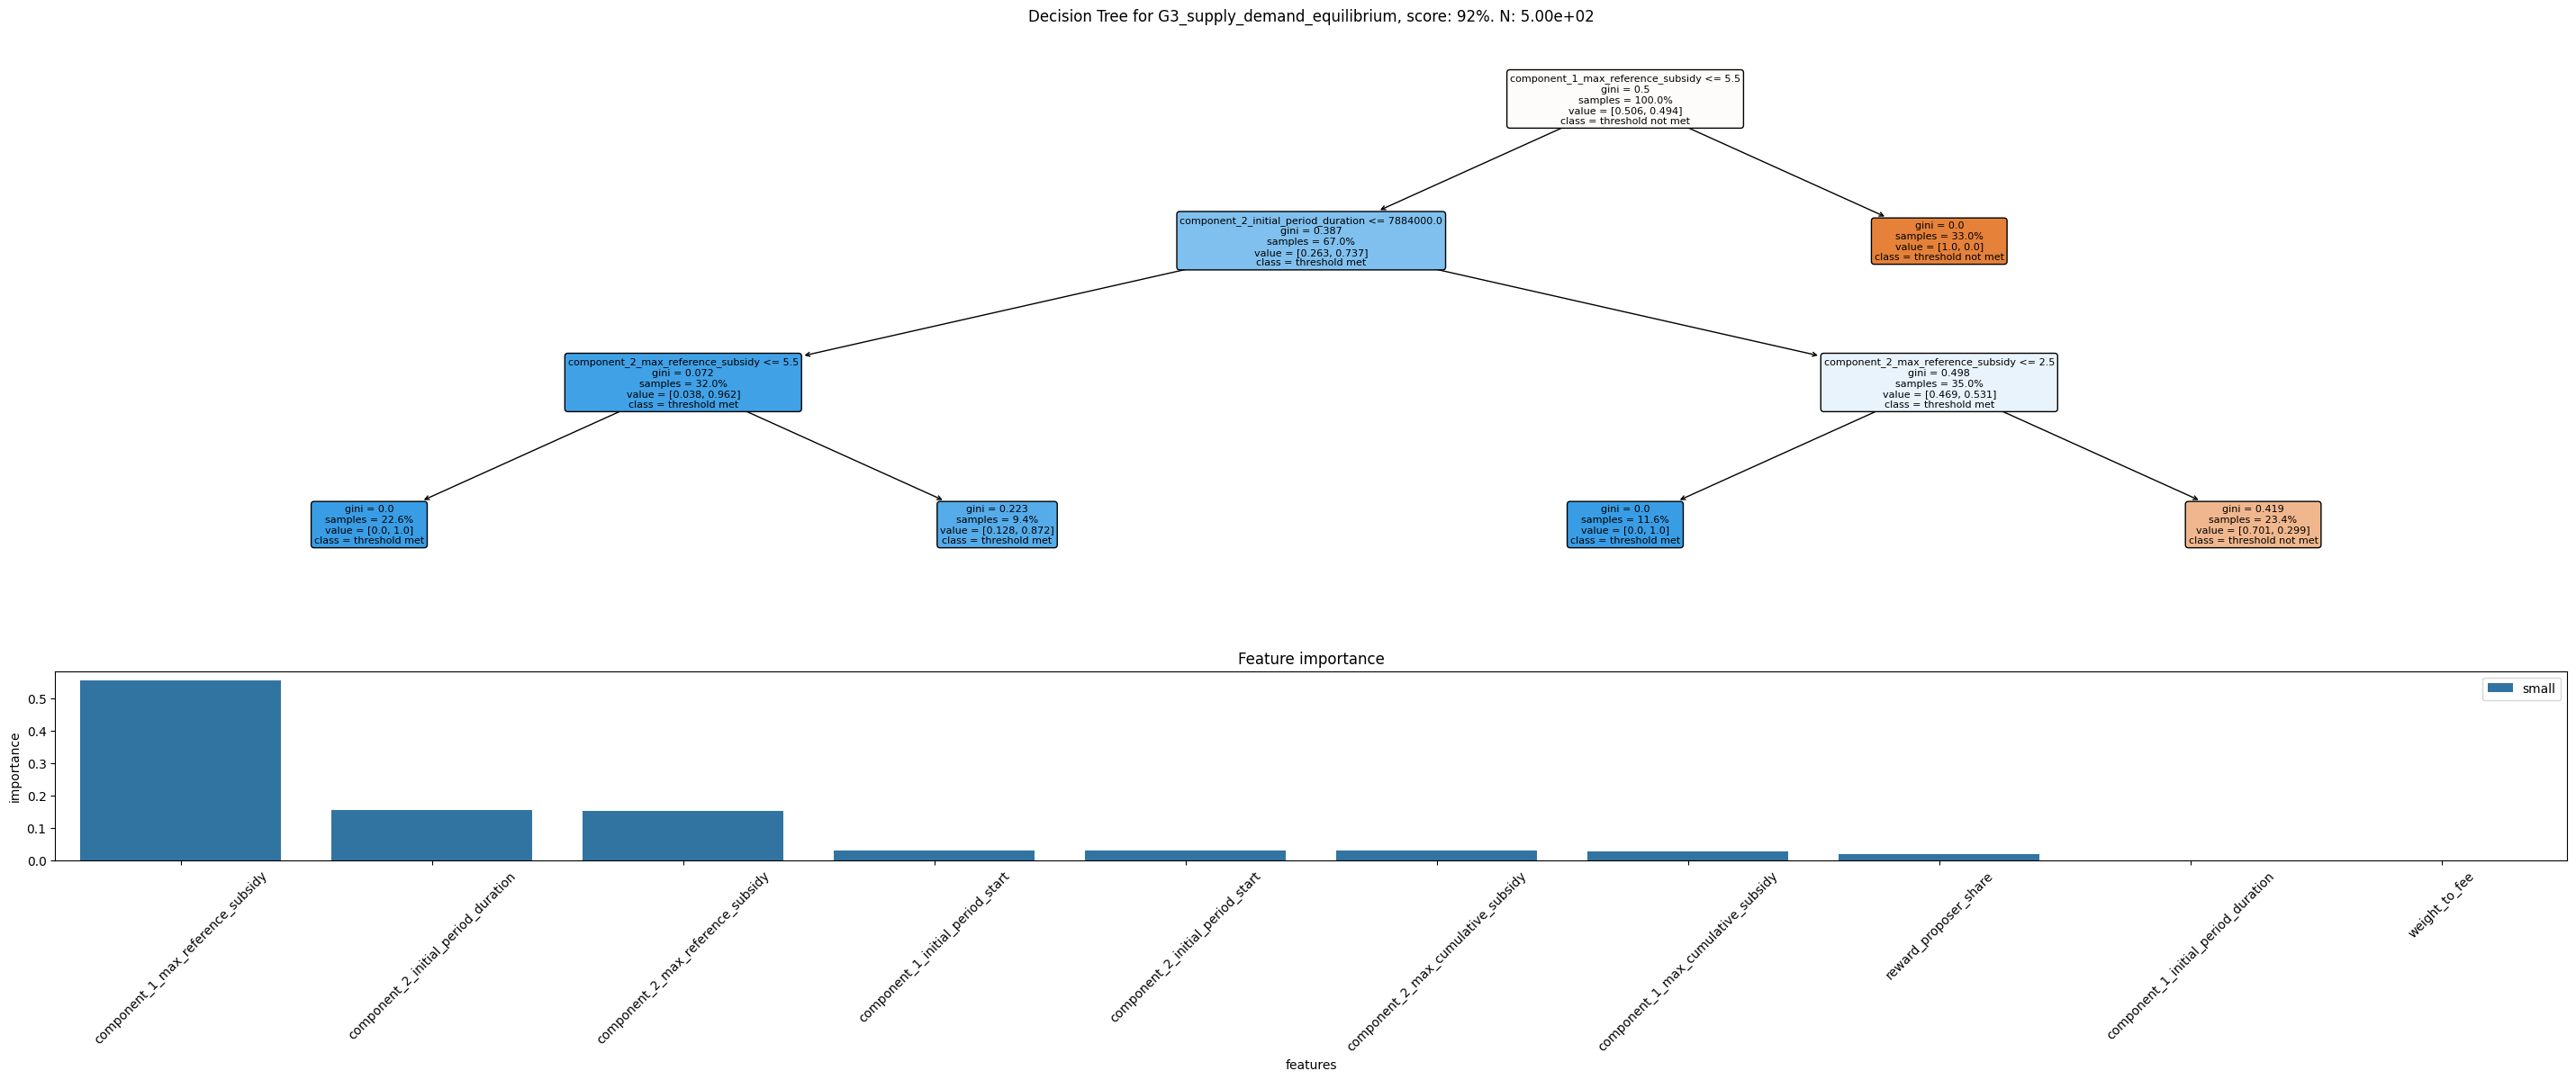

In [8]:
for goal, kpis in GOAL_KPI_GROUPS.items():
    goal_df = calculate_goal_score(agg_df, goal, goal)
    create_decision_tree_importances_plot(goal_df, goal, success_criteria='larger_than_median')


### Parameter Effect into KPIs

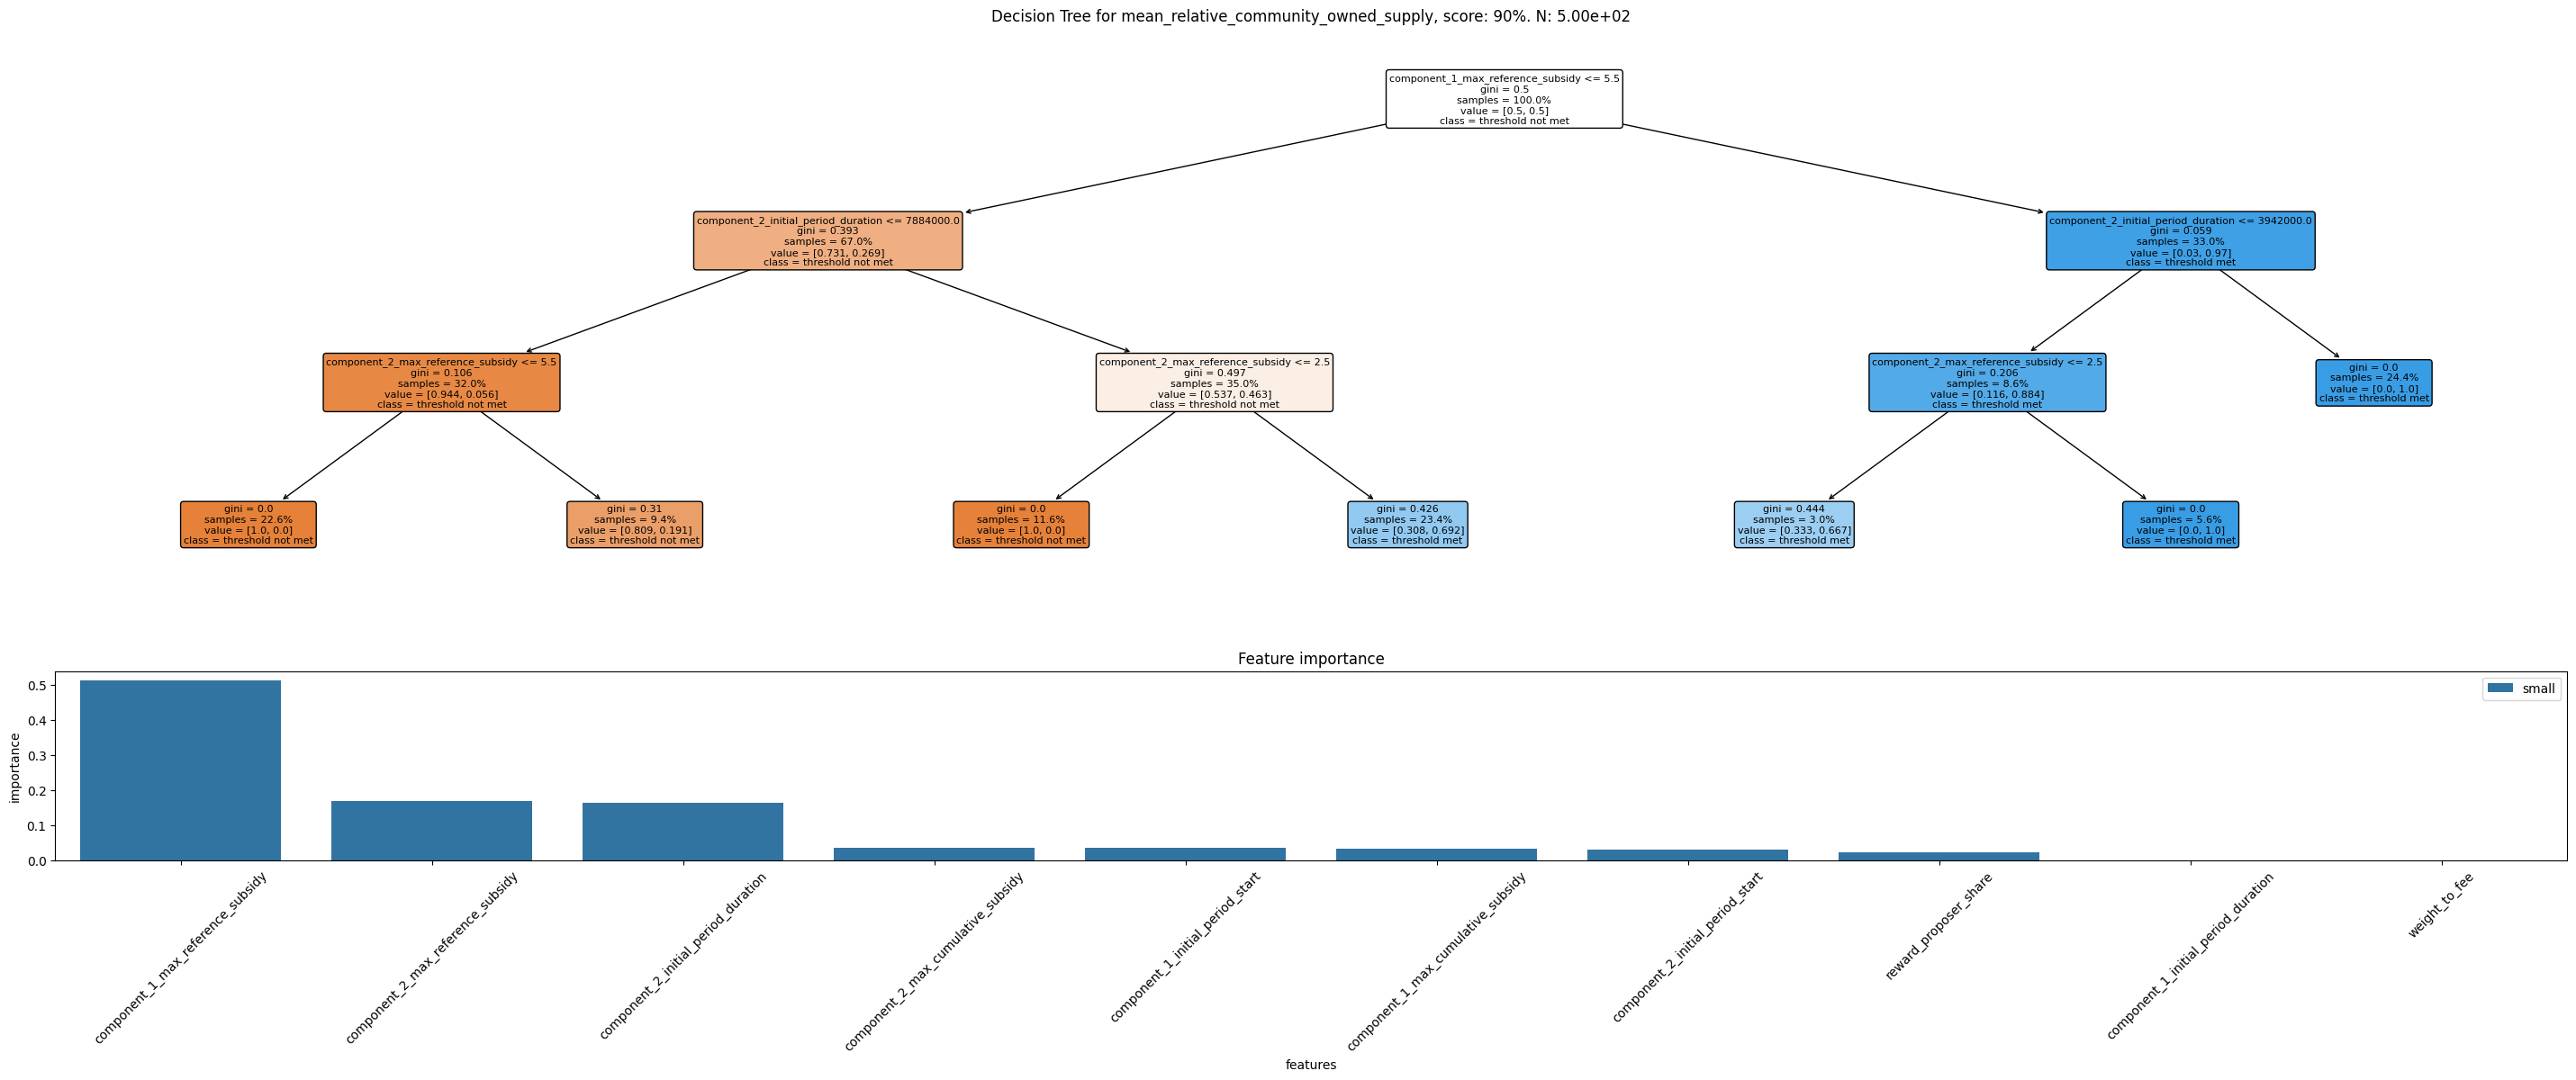

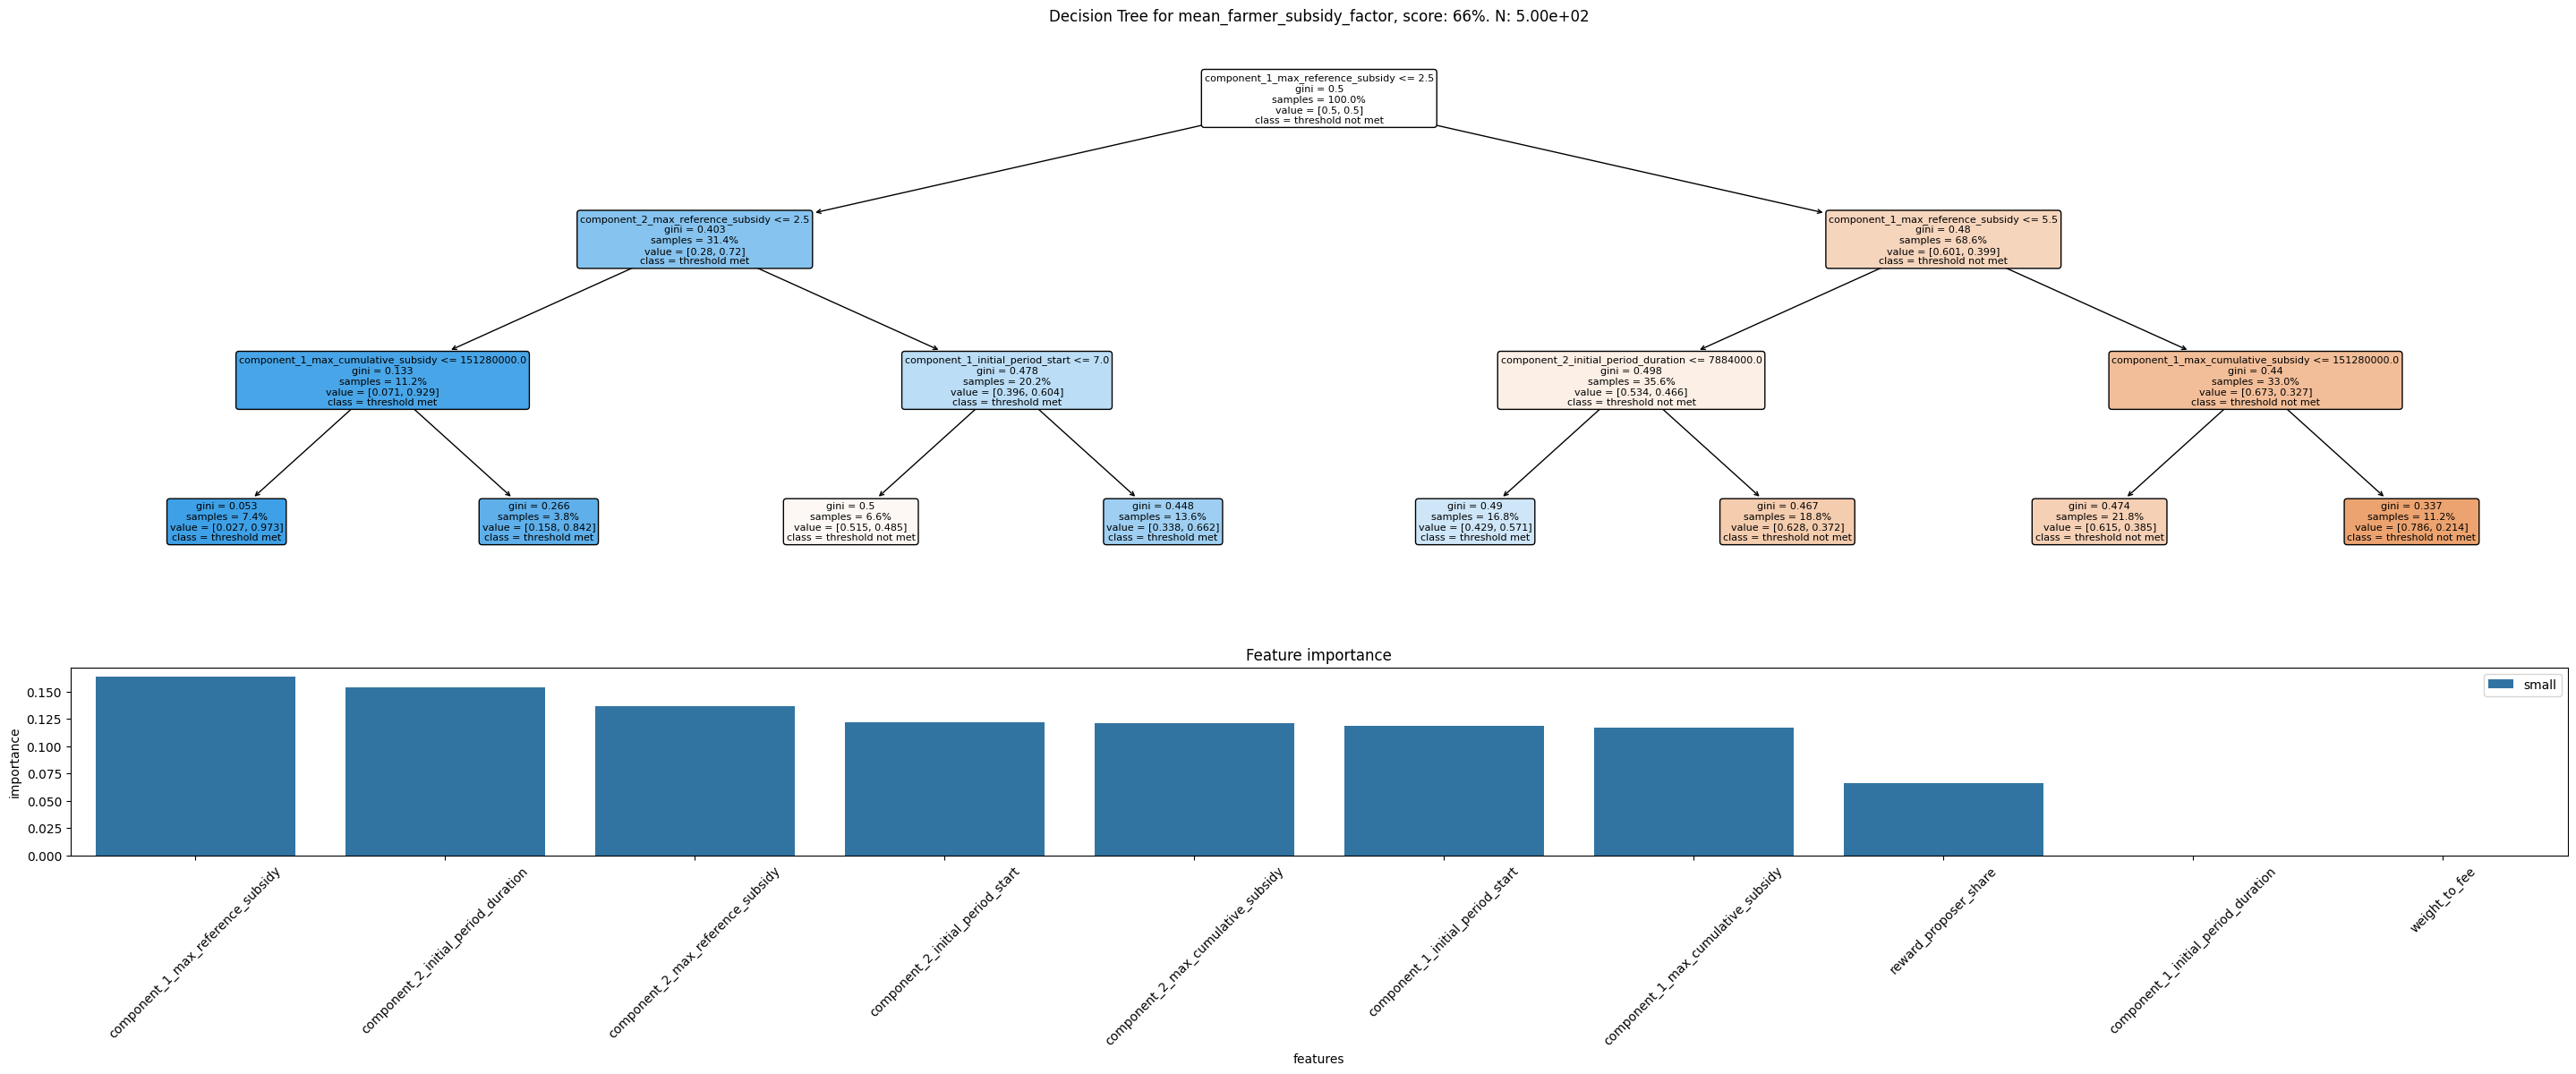

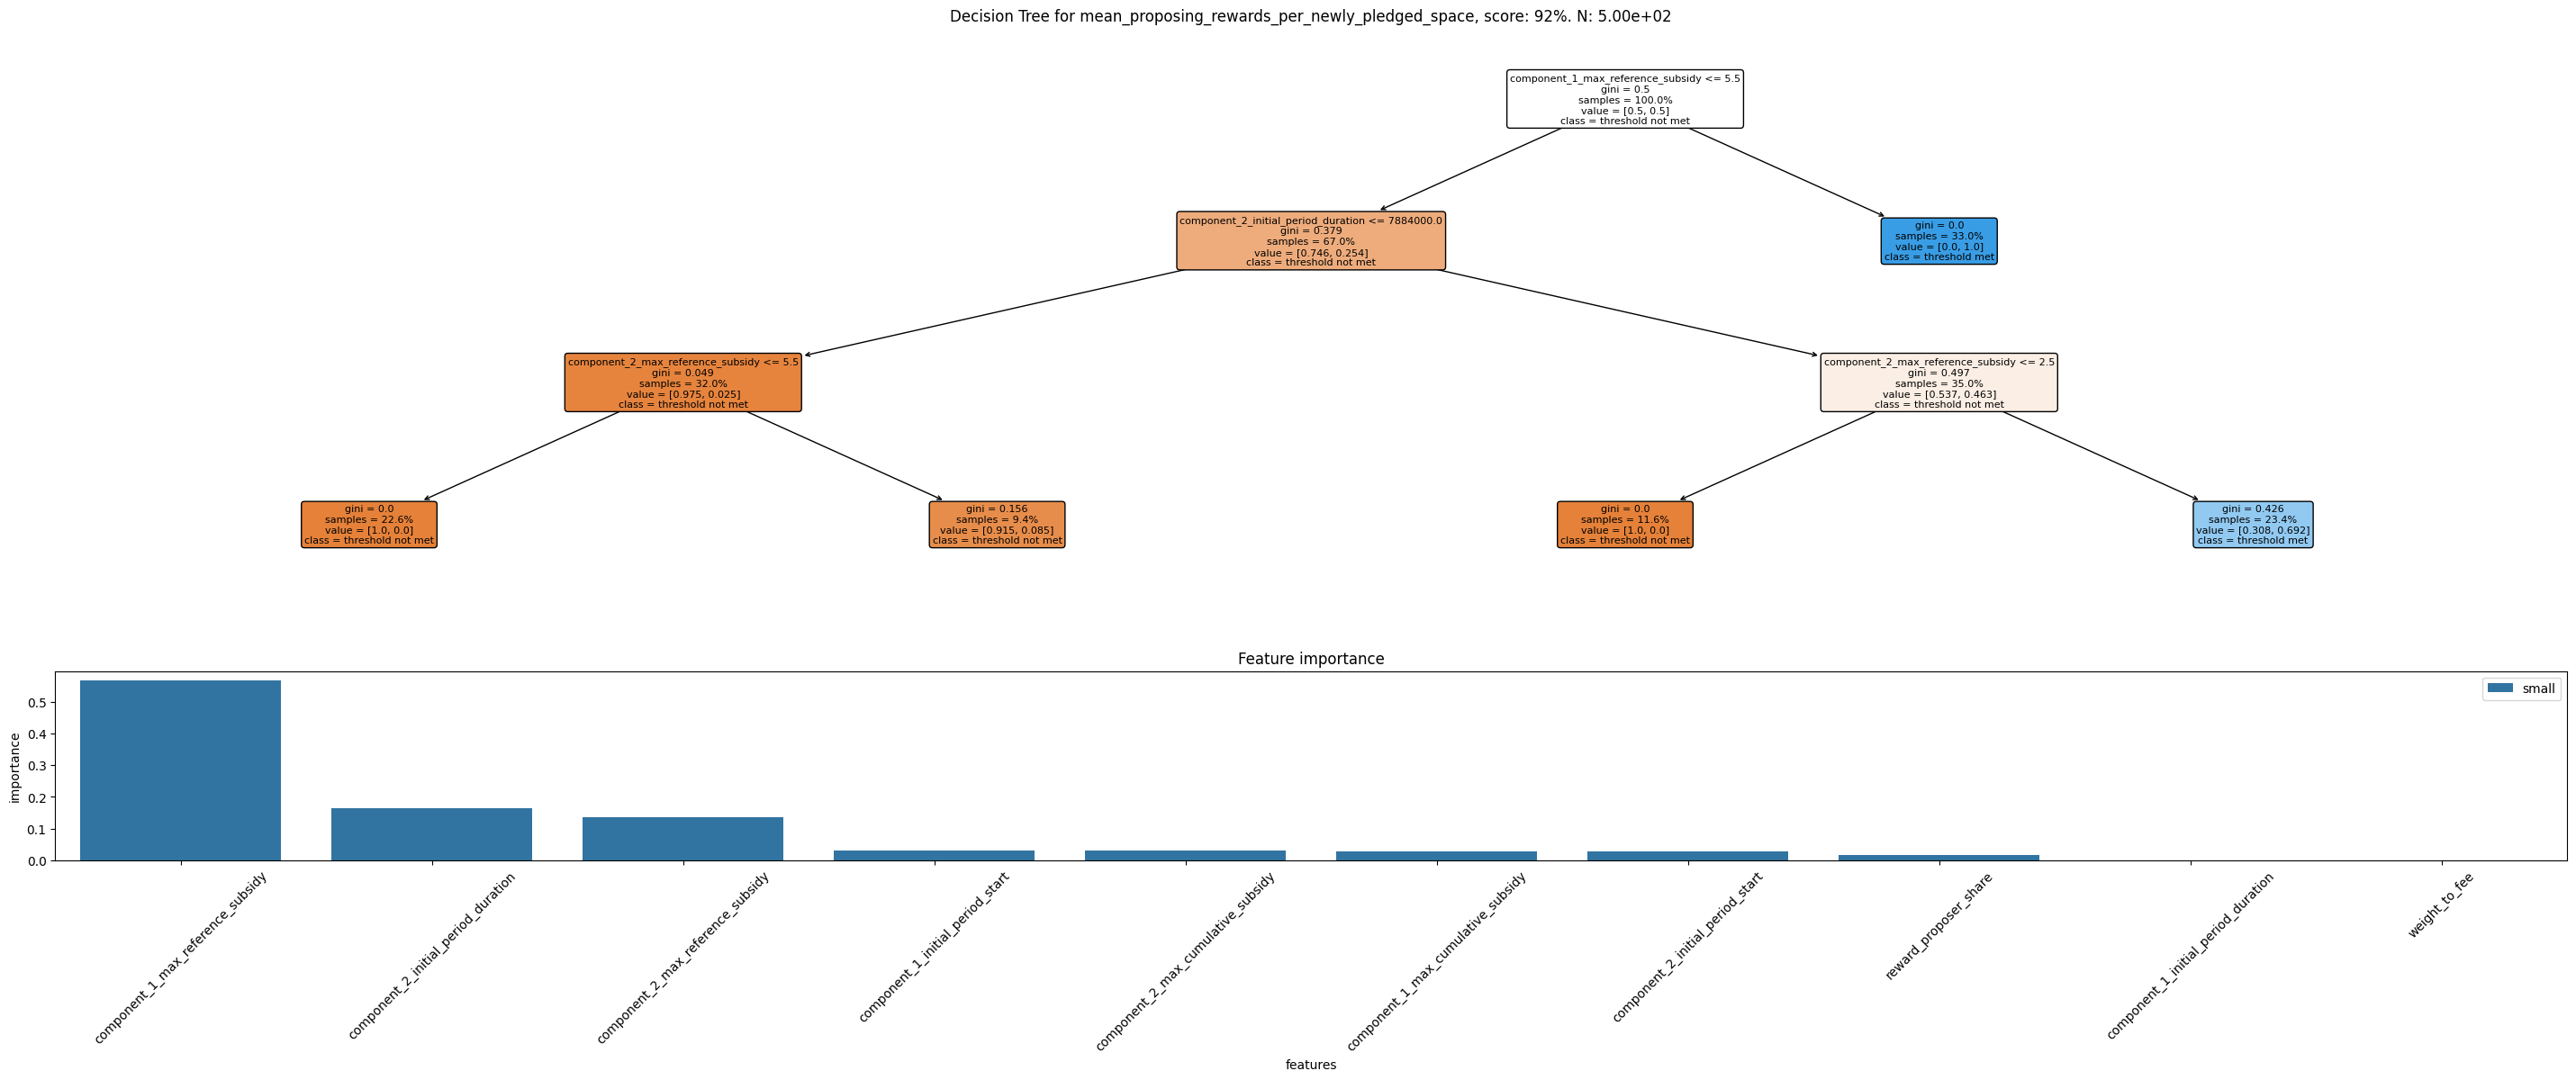

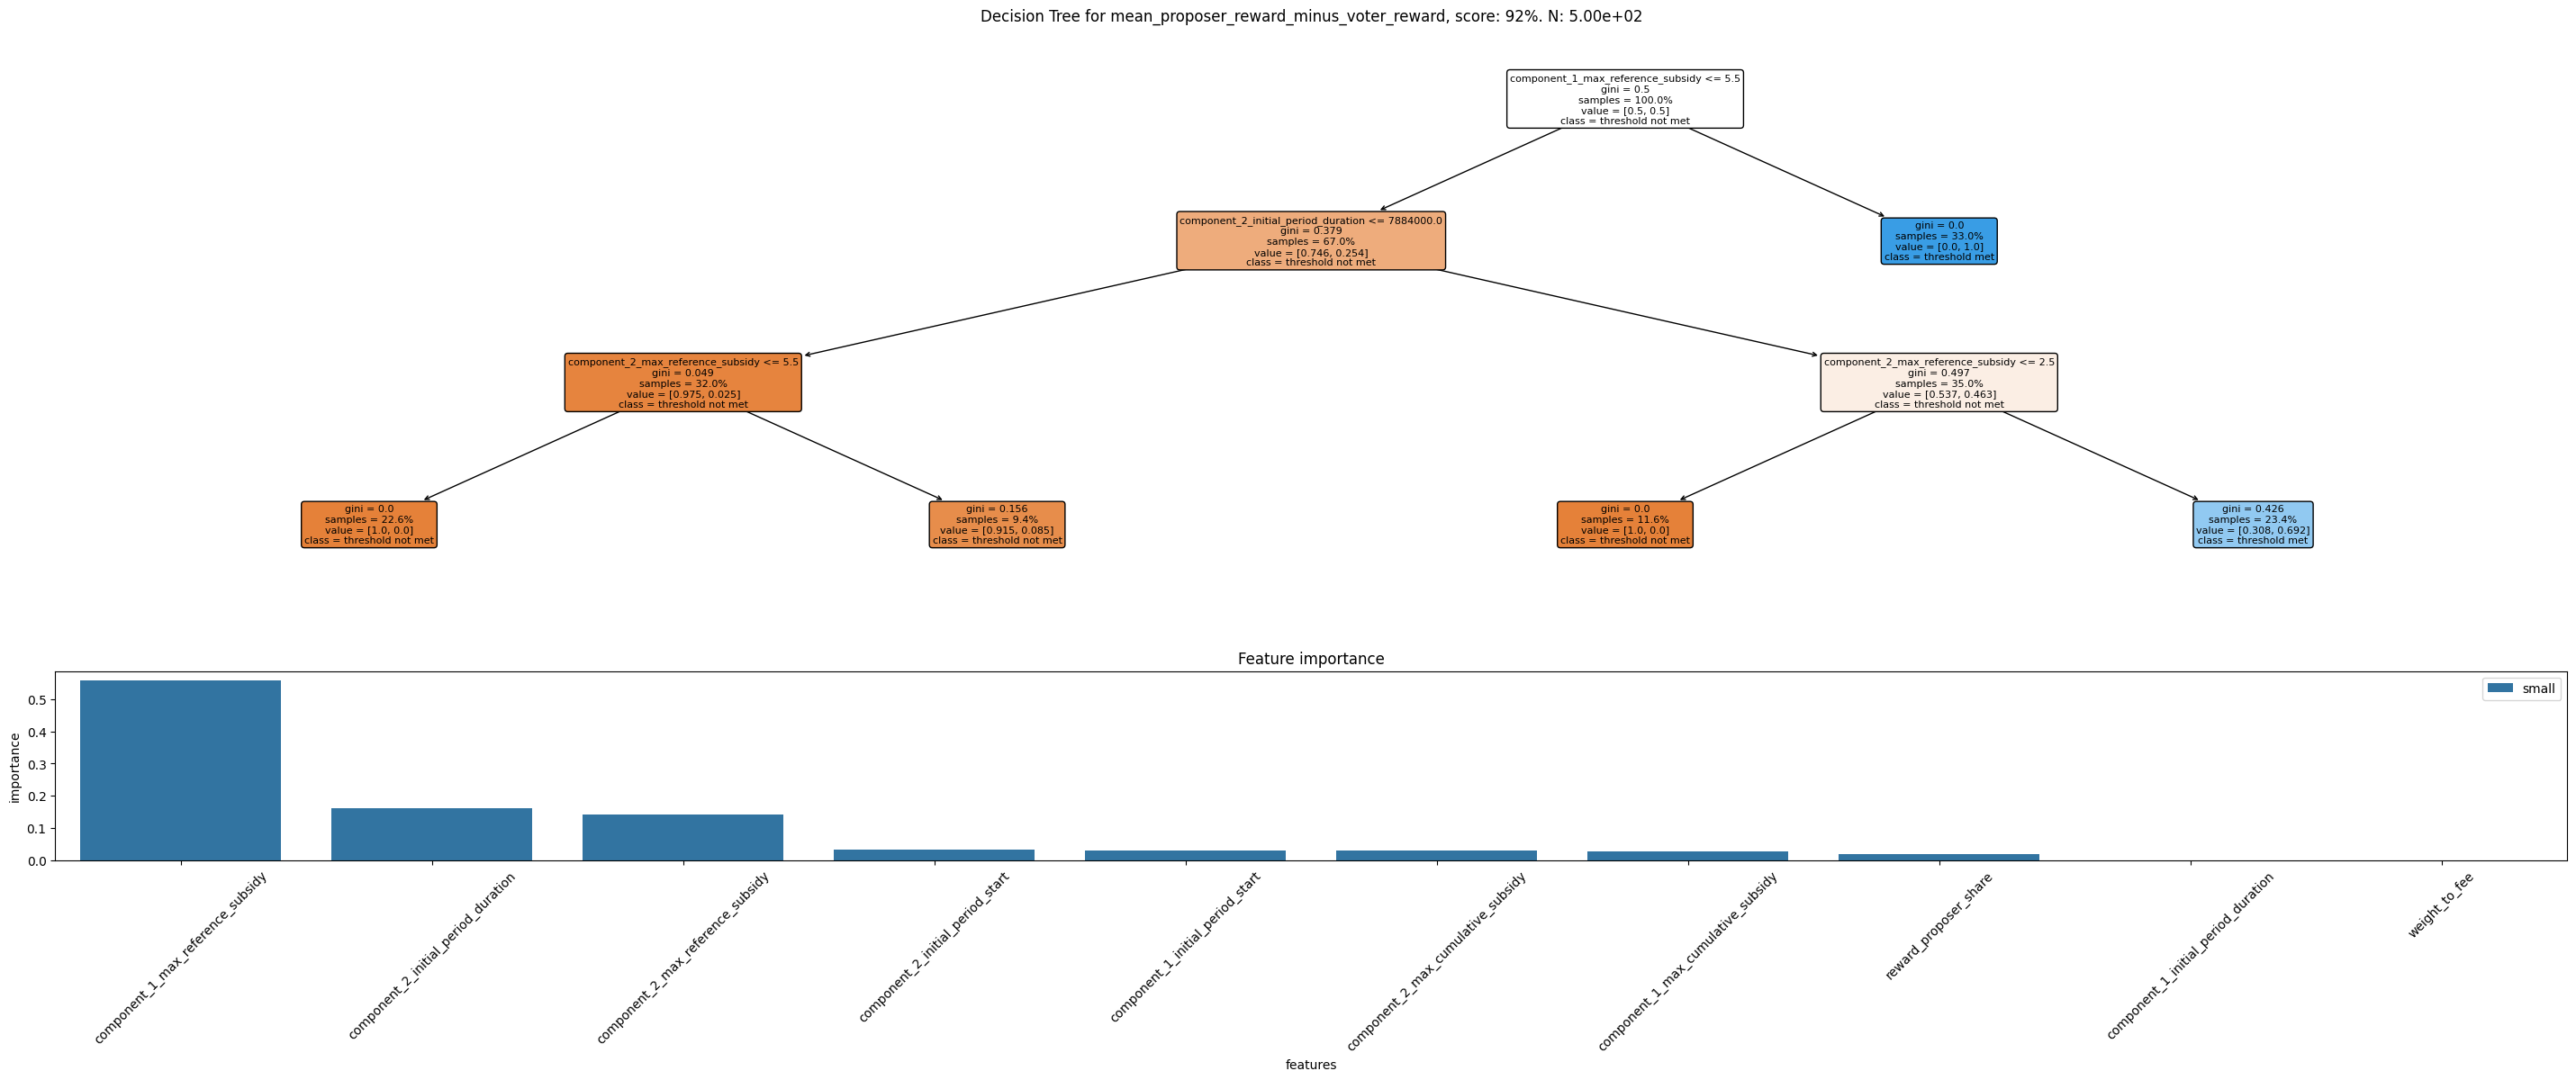

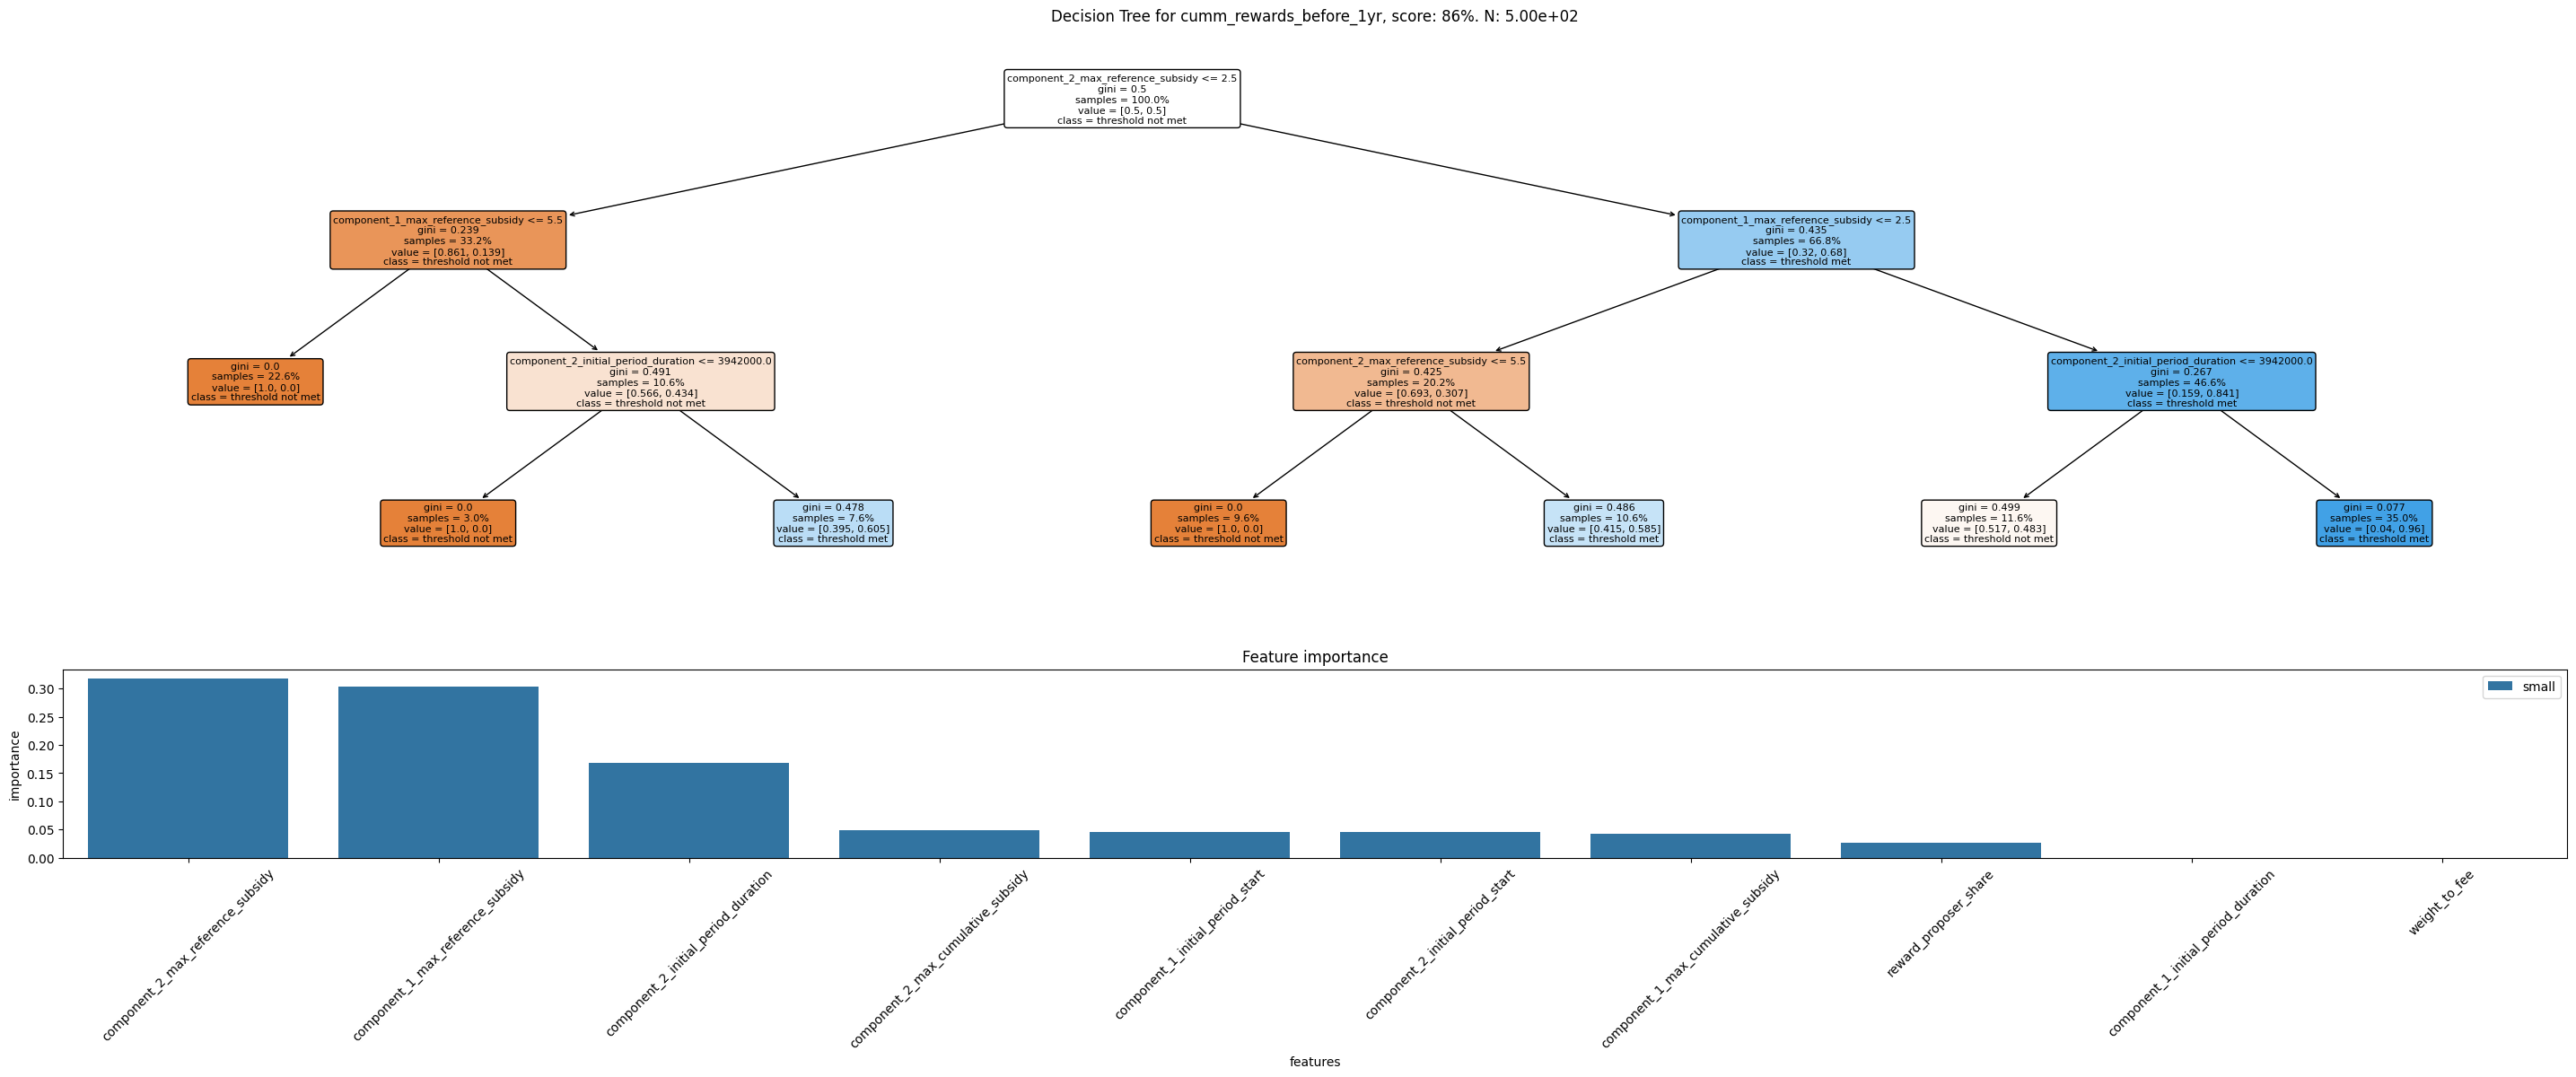

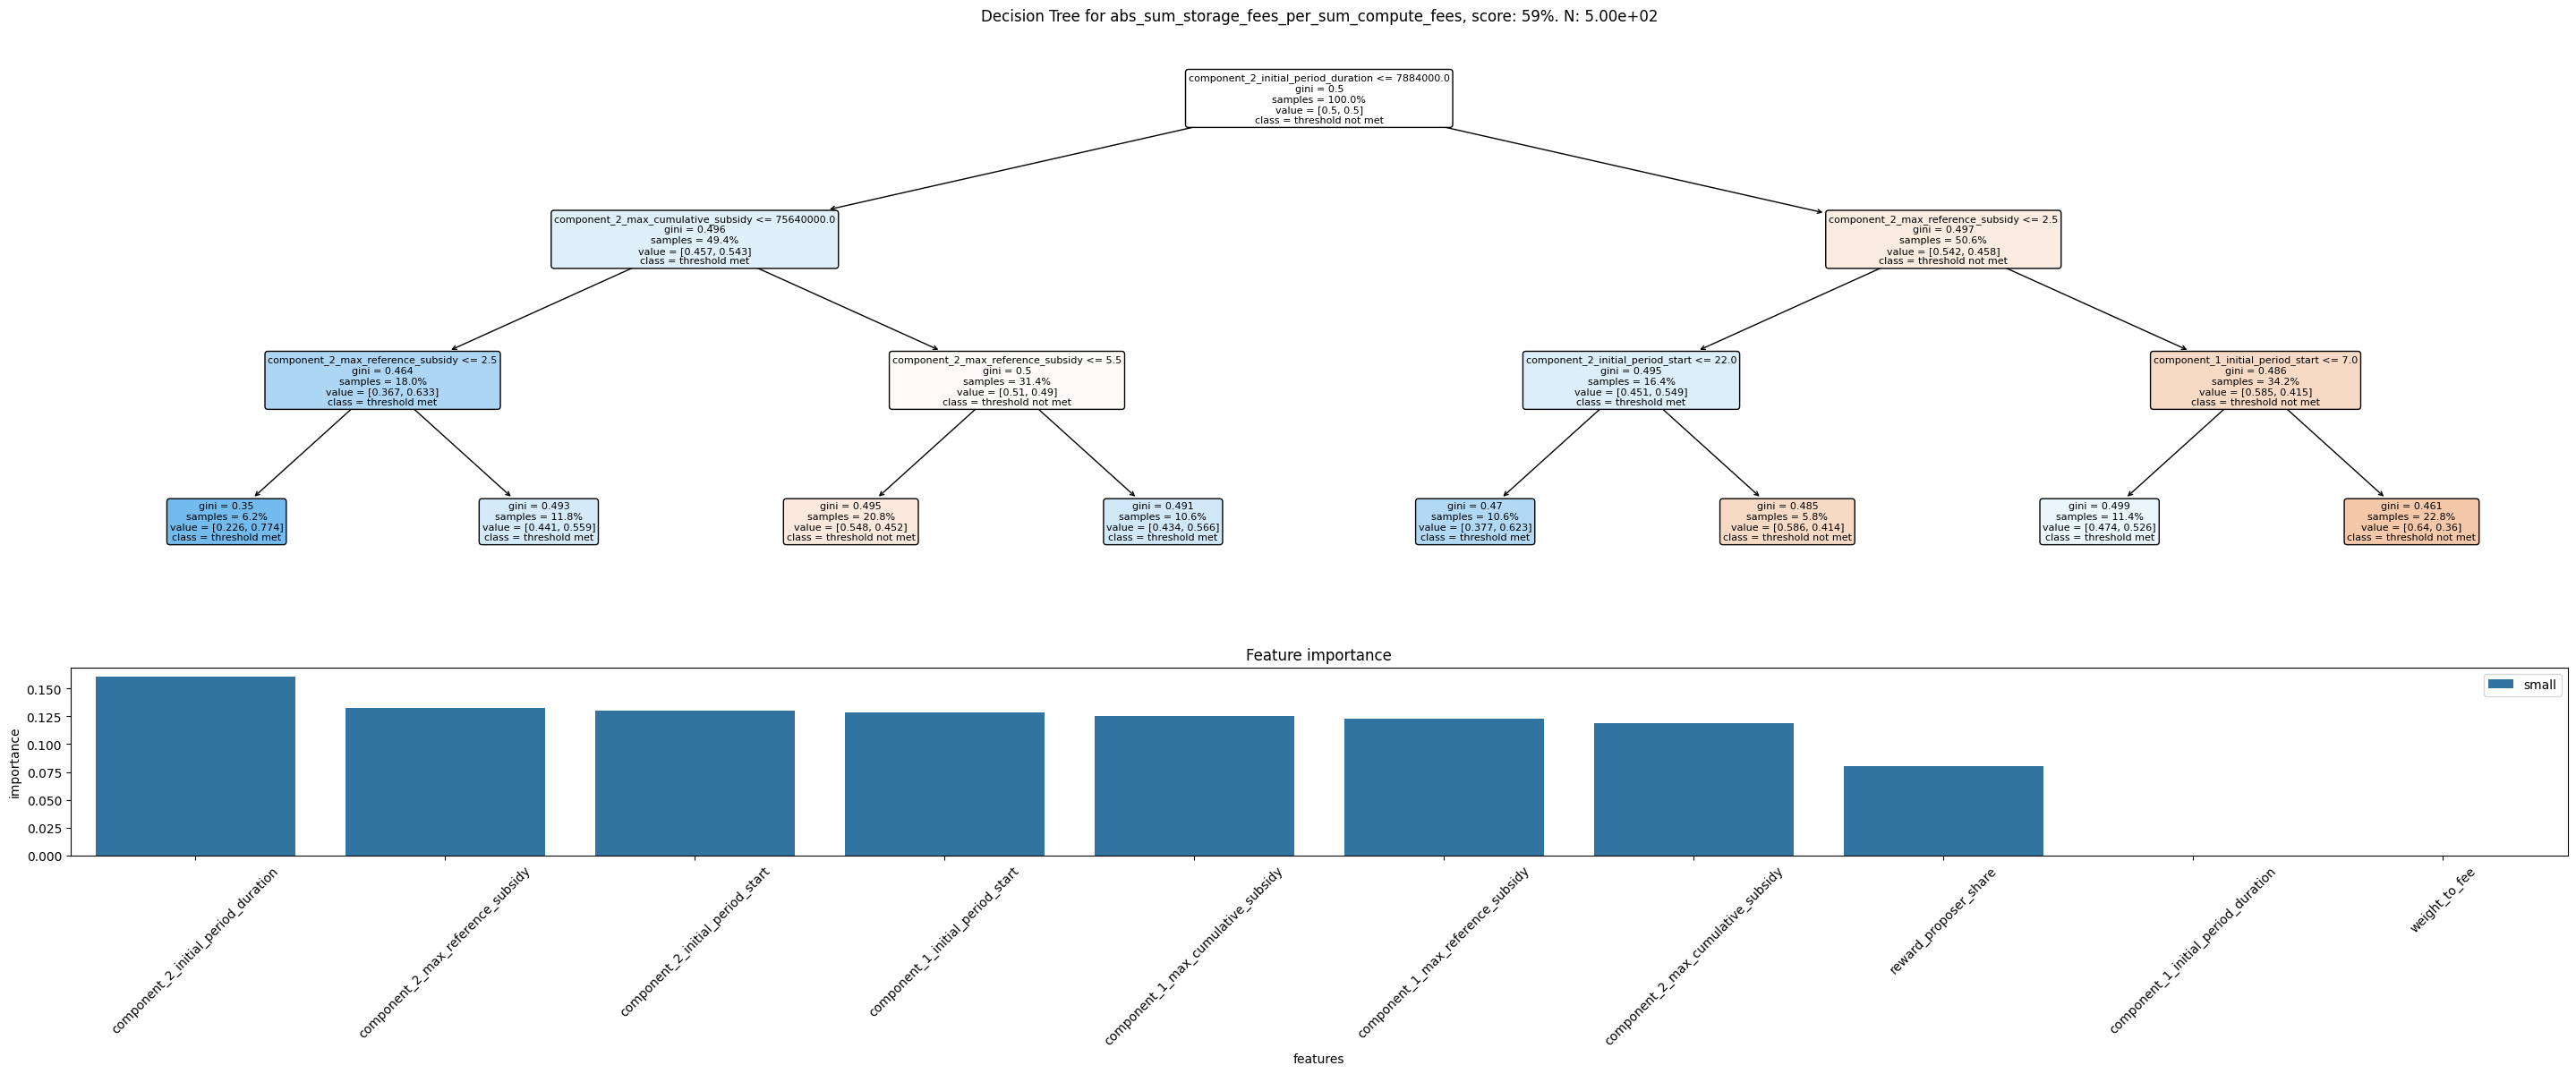

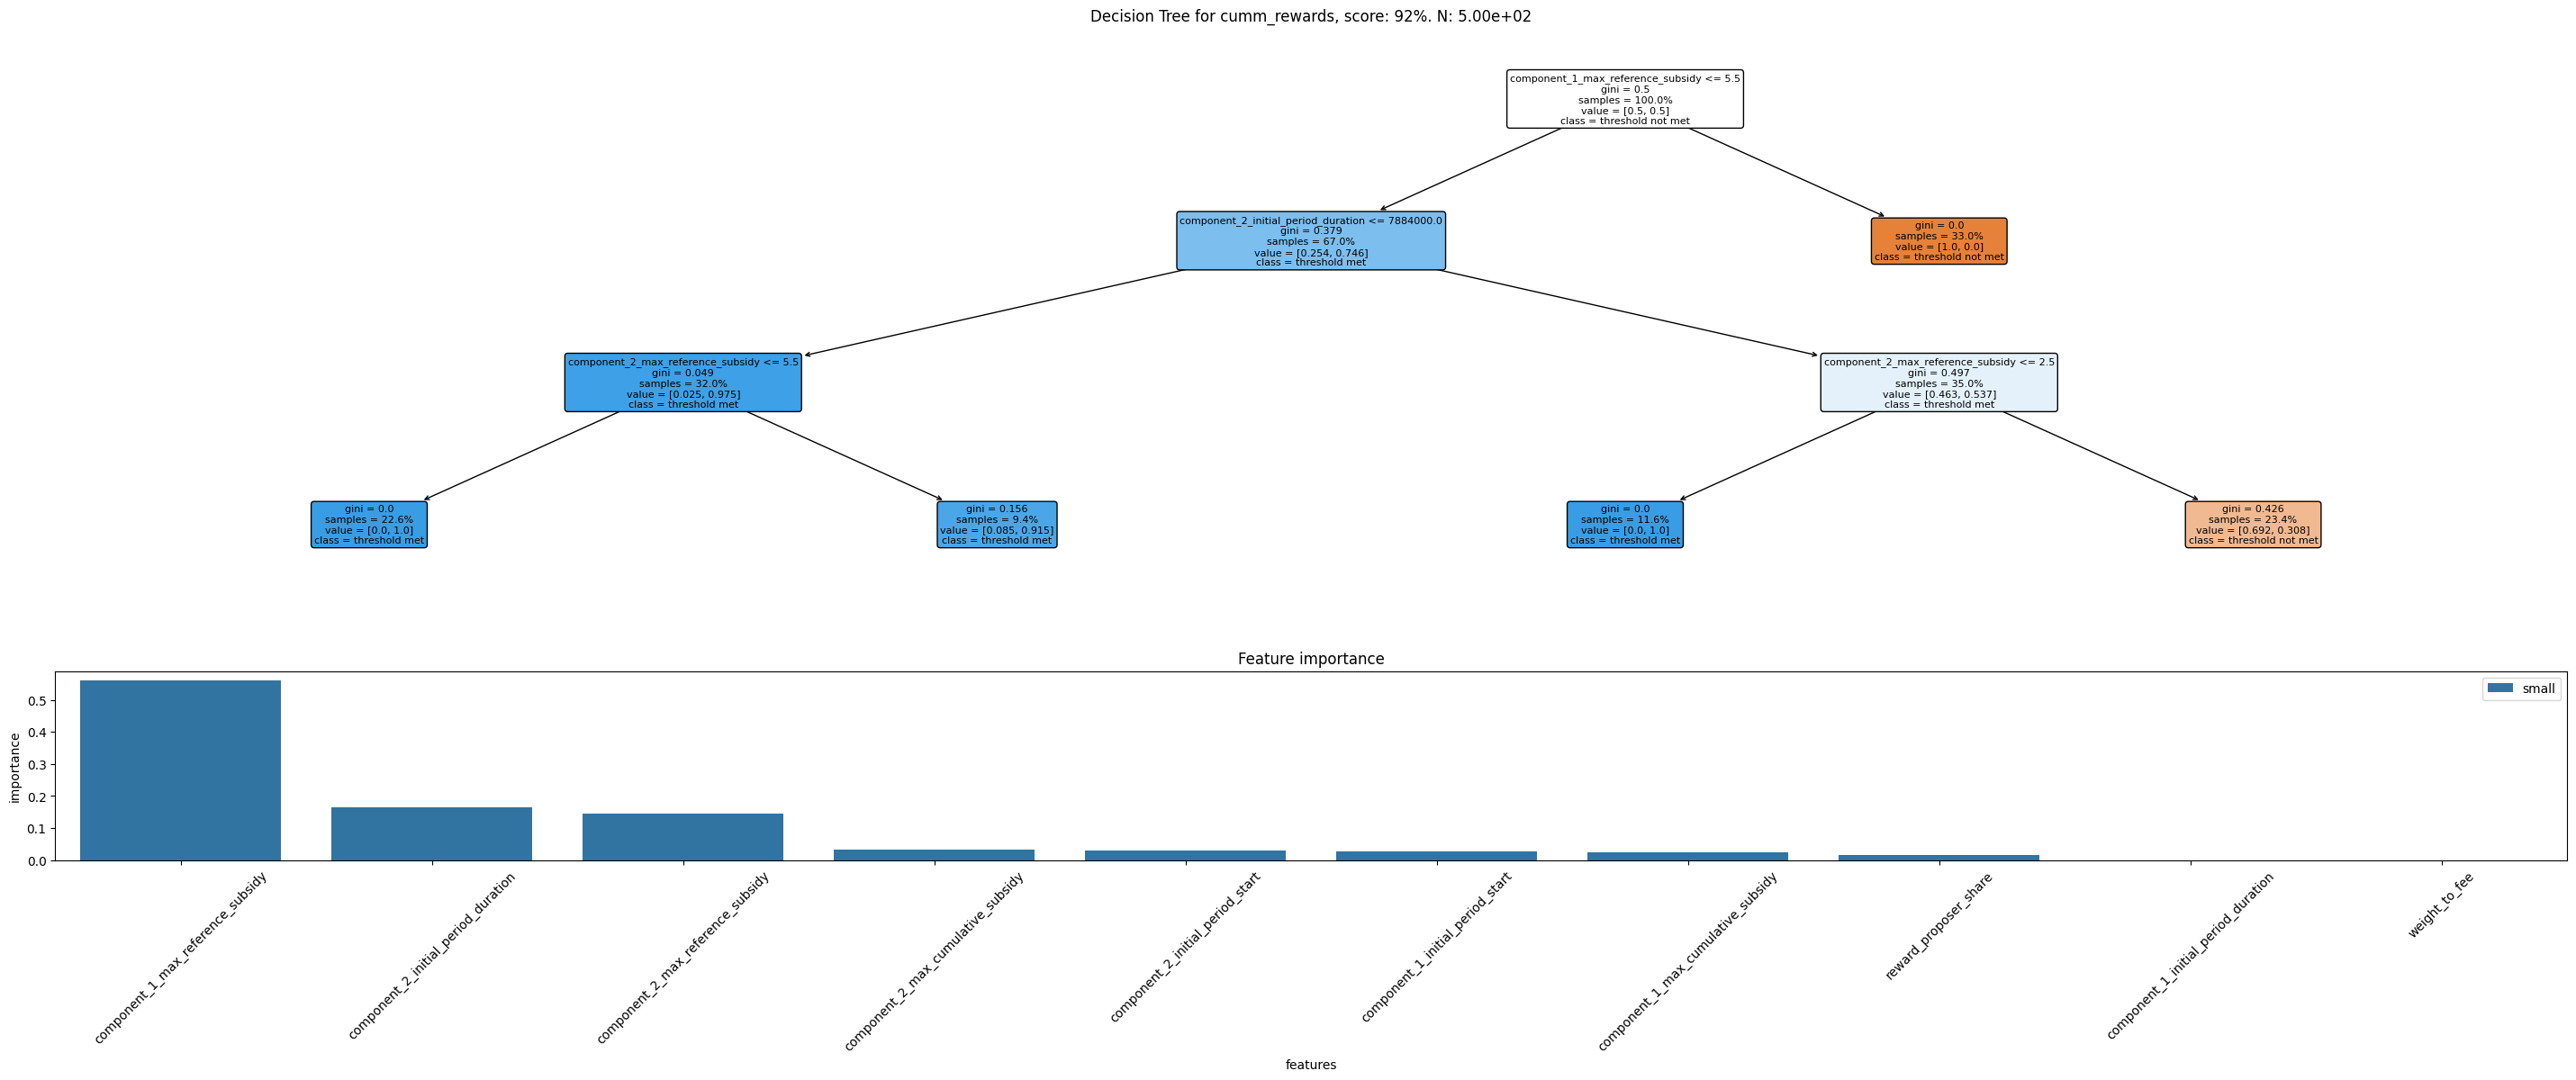

In [9]:
for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df,
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()

### Auxiliary Visualizations

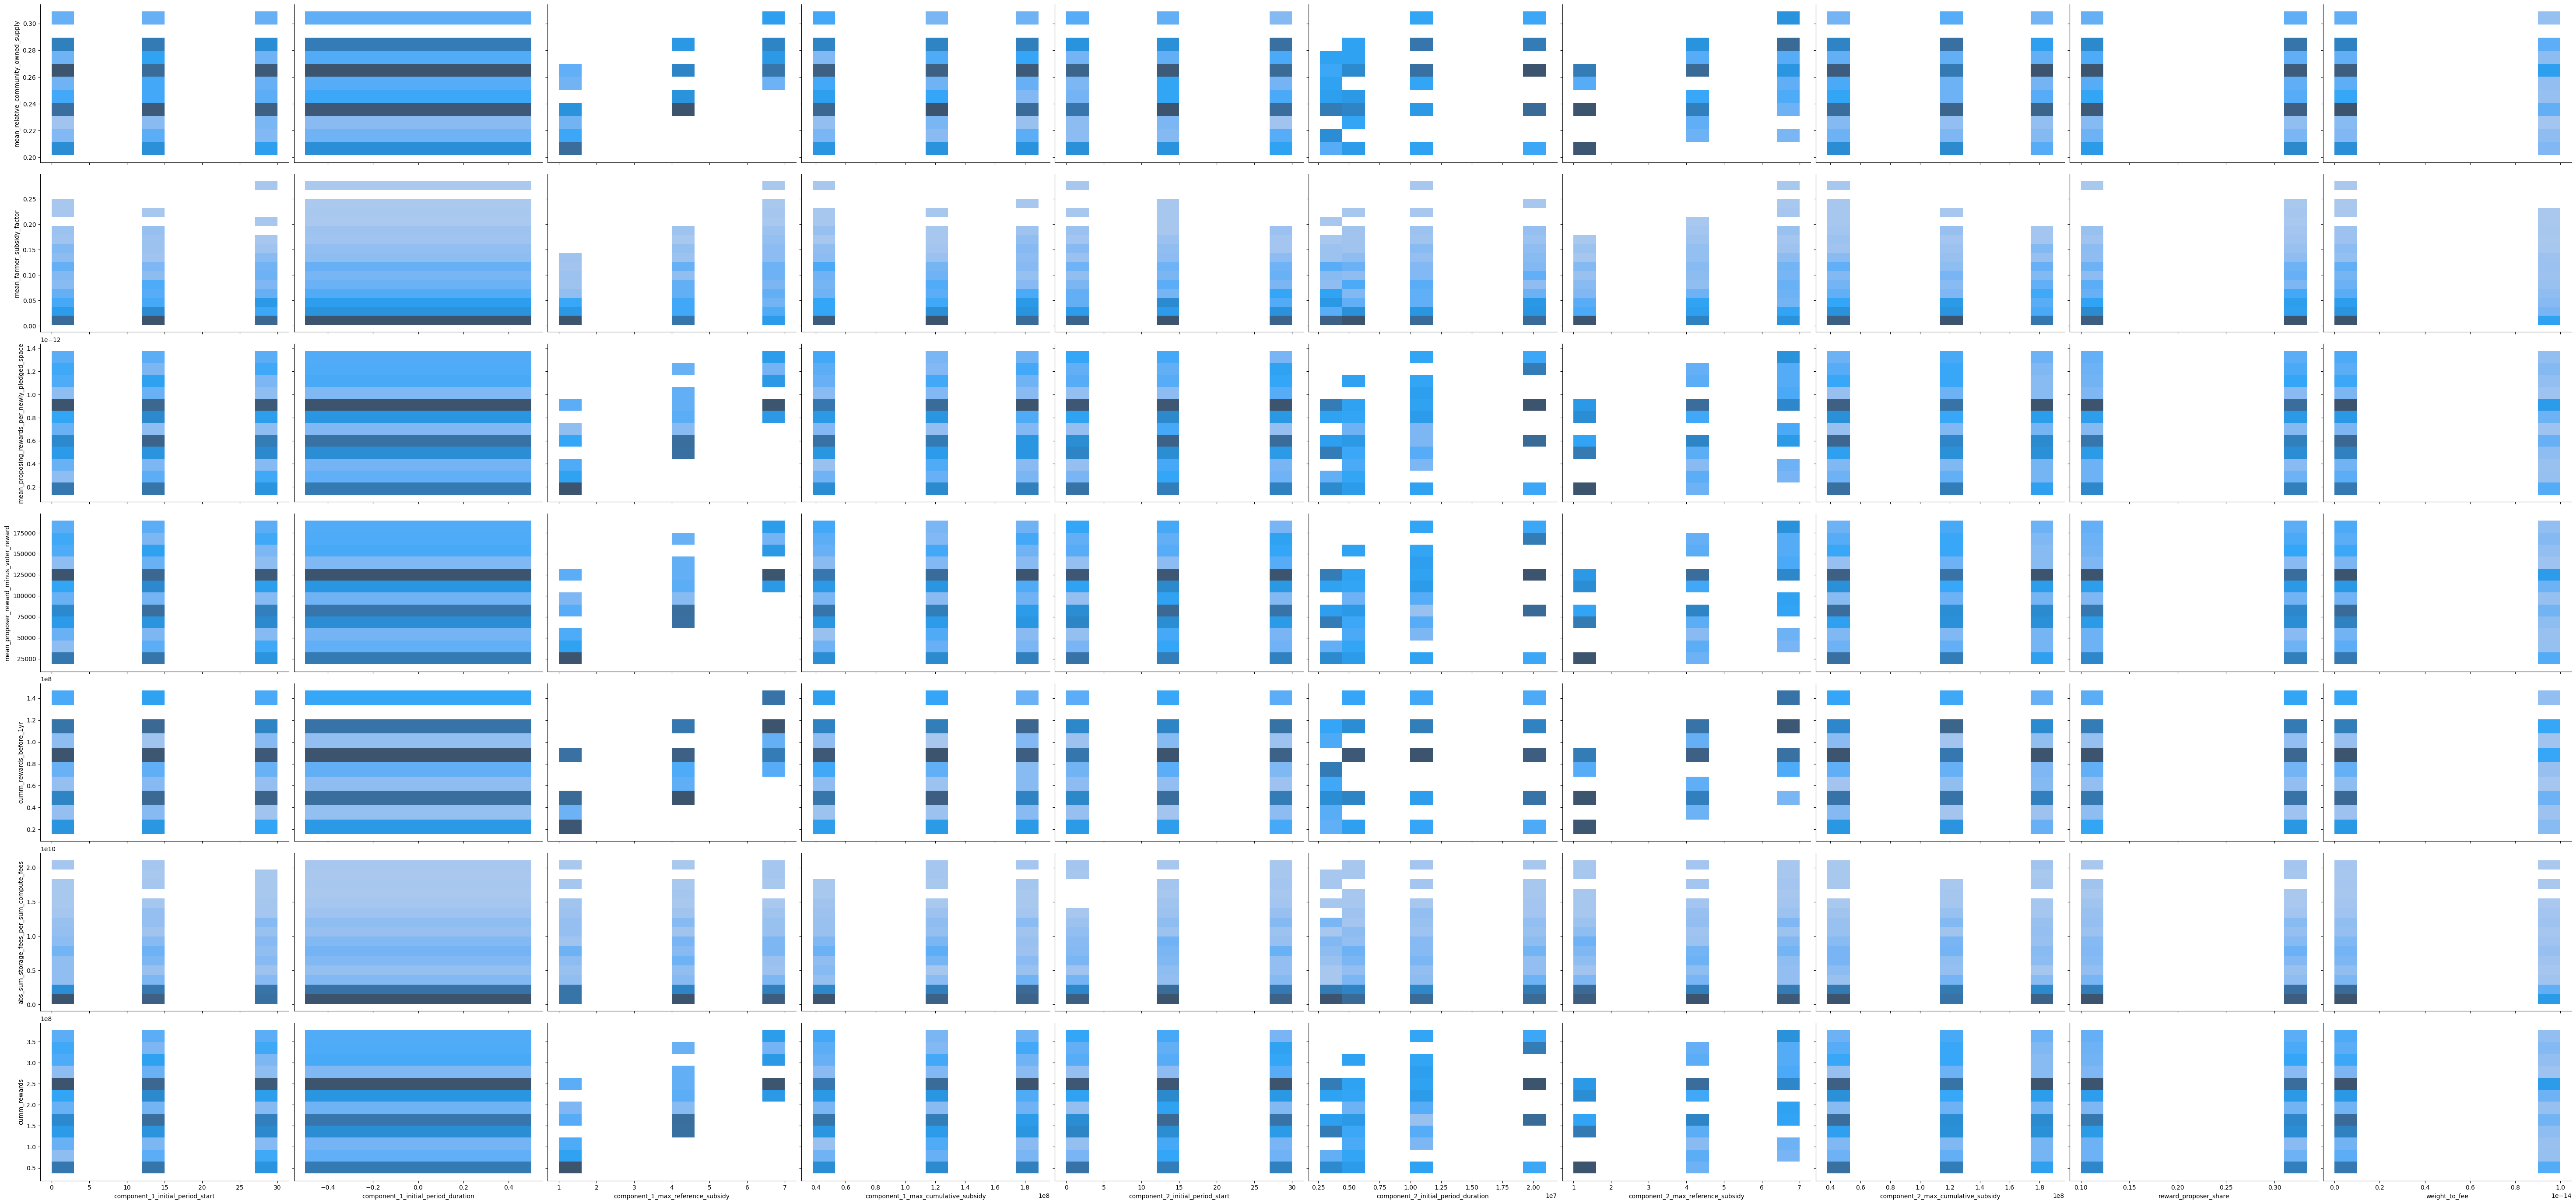

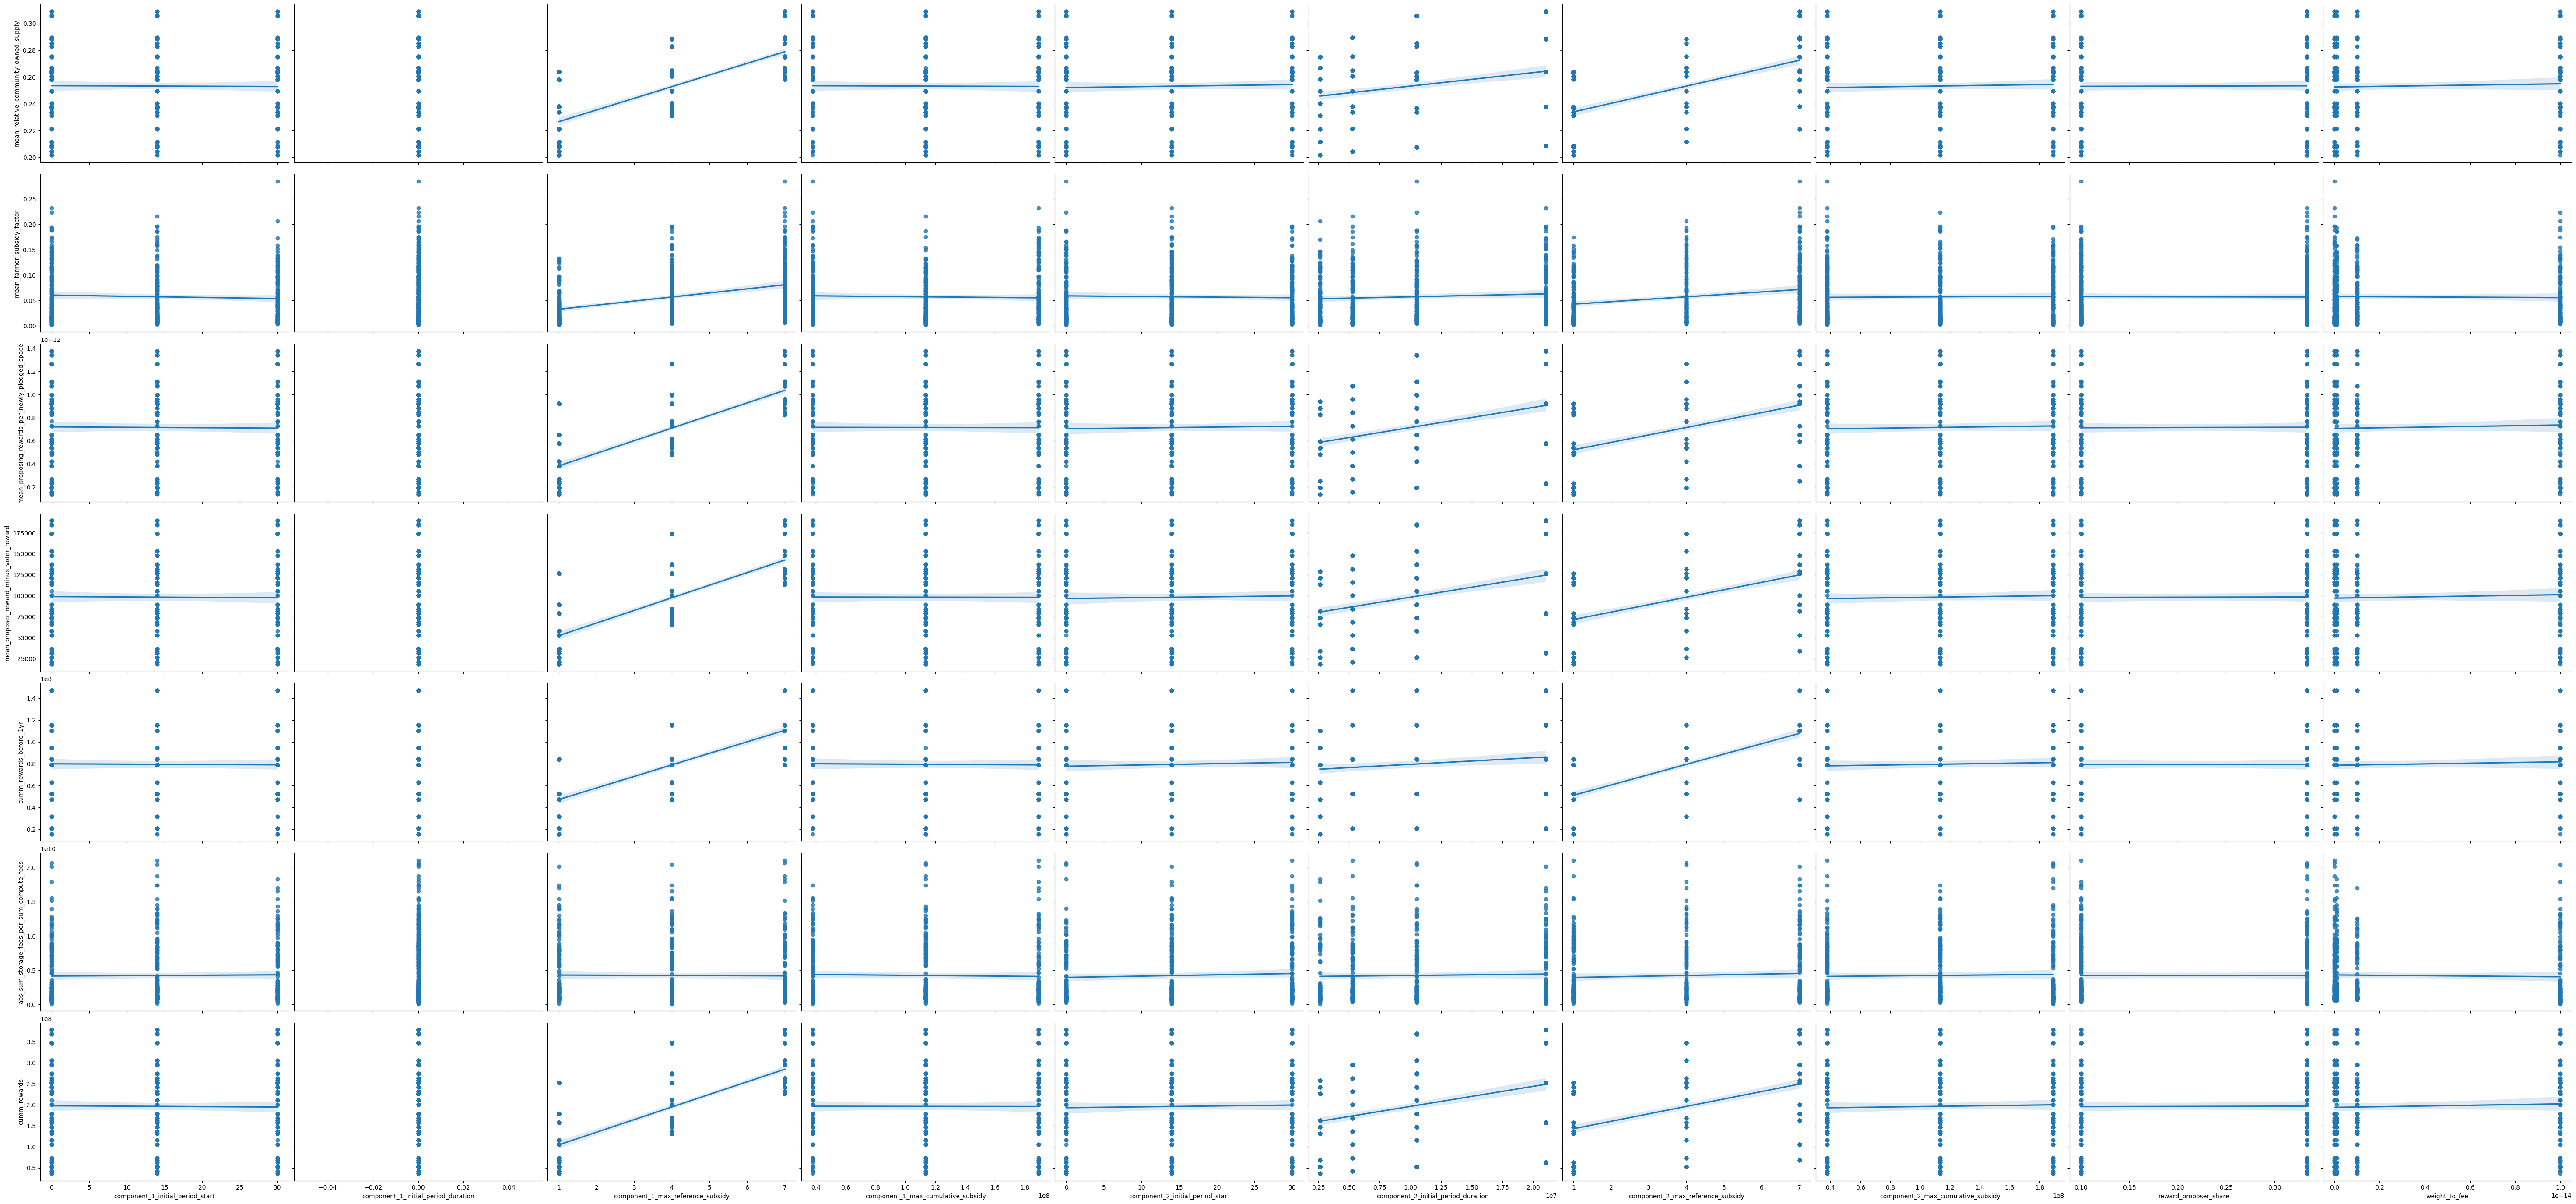

In [10]:
import seaborn as sns

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPI_functions)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')


In [11]:
agg_df

simulation  subset  run  component_2_max_reference_subsidy  \
0             0     240    1                                  7   
1             0     241    2                                  7   
2             0     242    3                                  1   
3             0     243    4                                  4   
4             0     244    5                                  4   
..          ...     ...  ...                                ...   
495           0     435   16                                  4   
496           0     436   17                                  1   
497           0     437   18                                  1   
498           0     438   19                                  7   
499           0     439   20                                  4   

     weight_to_fee  component_2_initial_period_duration  \
0     1.000000e-18                            2628000.0   
1     1.000000e-16                           21024000.0   
2     1.000000e-16                           10512000.0   
3     1.000000e-15                            2628000.0   
4     1.000000e-16                            5256000.0   
..             ...                                  ...   
495   1.000000e-16                           10512000.0   
496   1.000000e-16                           21024000.0   
497   1.000000e-18                           10512000.0   
498   1.000000e-16                           21024000.0   
499   1.000000e-18                           21024000.0   

     component_2_max_cumulative_subsidy  component_1_initial_period_start  \
0                           113460000.0                                 0   
1                            37820000.0                                14   
2                            37820000.0                                 0   
3                           113460000.0                                14   
4                           189100000.0                                 0   
..                                  ...                               ...   
495                          37820000.0                                 0   
496                         189100000.0                                14   
497                         189100000.0                                 0   
498                         189100000.0                                30   
499                         189100000.0                                 0   

     component_1_max_reference_subsidy  component_2_initial_period_start  \
0                                    7                                 0   
1                                    7                                30   
2                                    7                                14   
3                                    4                                 0   
4                                    4                                 0   
..                                 ...                               ...   
495                                  7                                30   
496                                  1                                30   
497                                  7                                14   
498                                  4                                 0   
499                                  7                                14   

     reward_proposer_share  component_1_max_cumulative_subsidy  \
0                 0.333333                         113460000.0   
1                 0.333333                          37820000.0   
2                 0.333333                         189100000.0   
3                 0.333333                         189100000.0   
4                 0.100000                          37820000.0   
..                     ...                                 ...   
495               0.100000                          37820000.0   
496               0.100000                         189100000.0   
497               0.100000                         18910000

In [12]:
for k in KPI_functions.keys():
    c = agg_df[k].value_counts()
    if len(c) <= 10:
        print(c)

In [13]:
d = agg_df[KPI_functions.keys()].describe().T
d['mean']

mean_relative_community_owned_supply              2.532247e-01
mean_farmer_subsidy_factor                        5.723837e-02
mean_proposing_rewards_per_newly_pledged_space    7.147134e-13
mean_proposer_reward_minus_voter_reward           9.830160e+04
cumm_rewards_before_1yr                           7.953434e+07
abs_sum_storage_fees_per_sum_compute_fees         4.238662e+09
cumm_rewards                                      1.960670e+08
Name: mean, dtype: float64

In [14]:
d['std'] / d['mean']

mean_relative_community_owned_supply              0.110782
mean_farmer_subsidy_factor                        0.881883
mean_proposing_rewards_per_newly_pledged_space    0.483157
mean_proposer_reward_minus_voter_reward           0.483100
cumm_rewards_before_1yr                           0.447273
abs_sum_storage_fees_per_sum_compute_fees         1.027981
cumm_rewards                                      0.483100
dtype: float64